In [1]:
import json
import string
import pandas as pd
import numpy as np

In [2]:
# Read Summarisation Model results from json file.

with open("../data/Model_Results/summarisation_results.jsonl", 'r') as json_file:
    json_list = list(json_file)

    
summarisationResults = {}
for json_str in json_list:
    
    result = json.loads(json_str)
    summaryList = sorted(result["sentence_scores"], key=lambda x:x[1], reverse=True)[:4]
    summary = ""
    for sentence in summaryList:
        summary += sentence[0] + ' '
    
    summarisationResults[result["id"]] = summary

In [3]:
summarisationData = pd.DataFrame(data=summarisationResults, index=[0])

In [4]:
summarisationDataDict = {}

for json_id in summarisationData.columns:
    
    features = {}
    
    features["summary"] = summarisationData[json_id].values[0]
    
    summarisationDataDict[json_id] = features

In [5]:
summarisationData = pd.DataFrame().from_dict(data=summarisationDataDict)

display(summarisationData)

,11972.json,11685.json,11096.json,5209.json,9524.json,5962.json,7070.json,1046.json,12849.json,13270.json,...,11576.json,3461.json,9464.json,10227.json,11707.json,3425.json,2977.json,294.json,3580.json,8384.json
summary,"""Building a wall"" on the border ""will take lit...","Those numbers show that as of October 2015, th...","If he did, he would have known that Senator Mc...","""…She supports taking $500 billion away from M...","Scott Walker helped run a ""criminal scheme"" to...",The campaign accurately quoted a figure whose ...,"So $30-31 million per year would, in fact, be ...",The Obama administration has emphasized many o...,"""It matters who’s leading the country, and it ...","Pence described the donors as major. ""The nati...",...,We’re not sure Sanders made that entirely clea...,"The $20 million designated for Cuba ""focuses o...",There also are no Asian or Pacific Islander Re...,"""The United States is in the longest stretch o...","""Secretary Clinton changes her position on thi...","Under the header ""New jobs created by the Stre...","They said low pay, increased work demands and ...","• Comstock, an adviser and frequent spokeswoma...","""House Republicans under Paul Ryan's leadershi...","""I will work in a bipartisan way to get it don..."


In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

In [7]:
def addSummary(data, summaries):
    
    for index, row in data.iterrows():
        if row["json_id"] in summaries.columns:
            row["summary"] = summaries[row["json_id"]].values[0]

In [8]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/vassilis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vassilis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [145]:
def cleanAndStemm(sentence):
    
    stop_words = set(stopwords.words('english'))
    wordnet_lemmatizer = WordNetLemmatizer()
    
    sentenceList = []
    for token in sentence.split(' '):
        
        token = token.lower()
        token = token.translate(str.maketrans('', '', string.punctuation))
        token = token.replace('$', '')
        
        if token.startswith('@') or token.startswith('#'):
            continue
        
        token = ''.join(e for e in token if e.isalnum())
        token = ''.join([i for i in token if not i.isdigit()])
        
        if token == '':
            continue
        
#         if token in stop_words:
#             continue
        
        token = wordnet_lemmatizer.lemmatize(token)
        
        sentenceList.append(token)
        
    newSentence = ' '.join(sentenceList)
    return newSentence

In [256]:
def TenFoldValidation_TfIdf(summarisationData, classifier):
    
    accuracyResults = np.zeros([10])
    f1Results = np.zeros([10])
        
    for counter in range(10):
        x_trainDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/train' + str(counter + 1) + '.tsv', sep='\t')
        x_trainDf.columns = ["json_id", "claim", "justification_label"]

        x_testDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/test' + str(counter + 1) + '.tsv', sep='\t')
        x_testDf.columns = ["json_id", "claim", "justification_label"]
        
        x_valDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/val' + str(counter + 1) + '.tsv', sep='\t')
        x_valDf.columns = ["json_id", "claim", "justification_label"]
        
        x_trainDf = pd.concat([x_trainDf, x_valDf])    
        
        x_trainDf["summary"] = ""
        x_testDf["summary"]  = ""
        
        addSummary(x_trainDf, summarisationData)
        addSummary(x_testDf, summarisationData)
        
        y_trainDf = pd.DataFrame(data=x_trainDf["justification_label"])
        y_testDf  = pd.DataFrame(data=x_testDf["justification_label"])
        
        trainClaimSumm  = []
        yTrainLabels   = y_trainDf['justification_label'].tolist()

        testClaimSumm   = []
        yTestLabels    = y_testDf['justification_label'].tolist()

        for index, row in x_trainDf.iterrows():
            trainClaimSumm.append(cleanAndStemm(row['claim']) + cleanAndStemm(row['summary']))

        for index, row in x_testDf.iterrows():
            testClaimSumm.append(cleanAndStemm(row['claim']) + cleanAndStemm(row['summary']))

            
        # Convert words to number using Bag of Words (Bow)
        vectorizer = CountVectorizer(max_features=20)
        vectorizedTrain = vectorizer.fit_transform(trainClaimSumm).toarray()
        vectorizedTest  = vectorizer.fit_transform(testClaimSumm).toarray()

        # Convert Bow values according to TfIdf
        tfidfconverter = TfidfTransformer()
        XTrain = tfidfconverter.fit_transform(vectorizedTrain).toarray()
        XTest  = tfidfconverter.fit_transform(vectorizedTest).toarray()

        classifier.fit(XTrain,yTrainLabels)

        yPredLabels = classifier.predict(XTest)
        
        accuracyScore = accuracy_score(yTestLabels,yPredLabels)
        accuracyResults[counter] = accuracyScore
        
        f1Score = f1_score(yTestLabels,yPredLabels, average="macro")
        f1Results[counter] = f1Score

        ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
#         print(classification_report(yTestLabels,yPredLabels))
        print("Iteration:",counter+1," Accuracy Score: ",round(accuracyScore,2))
        print("Iteration:",counter+1," MacroF1 Score: ", round(f1Score,2))
        print("-------------------------------------")
    
    return accuracyResults, round(np.mean(f1Results),2), round(np.mean(accuracyResults),2)

In [250]:
def HyperParameterTuningTfIdf(summarisationData, classifier):

    bestKVal   = 0.0
    bestf1Val  = 0.0
    bestModel = None
    bestParameters = None

    for counter in range(10):
        x_trainDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/train' + str(counter + 1) + '.tsv', sep='\t')
        x_trainDf.columns = ["json_id", "claim", "justification_label"]

        x_valDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/val' + str(counter + 1) + '.tsv', sep='\t')
        x_valDf.columns = ["json_id", "claim", "justification_label"]

        x_trainDf["summary"] = ""
        x_valDf["summary"] = ""

        addSummary(x_trainDf, summarisationData)
        addSummary(x_valDf, summarisationData)

        y_trainDf = pd.DataFrame(data=x_trainDf["justification_label"])
        y_valDf = pd.DataFrame(data=x_valDf["justification_label"])

        trainClaimSumm  = []
        yTrainLabels   = y_trainDf['justification_label'].tolist()

        valClaimSumm  = []
        yValLabels   = y_valDf['justification_label'].tolist()

        for index, row in x_trainDf.iterrows():
            trainClaimSumm.append(cleanAndStemm(row['claim']) + cleanAndStemm(row['summary']))

        for index, row in x_valDf.iterrows():
            valClaimSumm.append(cleanAndStemm(row['claim']) + cleanAndStemm(row['summary']))


        # Convert words to number using Bag of Words (Bow)
        vectorizer = CountVectorizer(max_features=20)
        vectorizedTrain = vectorizer.fit_transform(trainClaimSumm).toarray()
        vectorizedVal = vectorizer.fit_transform(valClaimSumm).toarray()

        # Convert Bow values according to TfIdf
        tfidfconverter = TfidfTransformer()
        XTrain = tfidfconverter.fit_transform(vectorizedTrain).toarray()
        XVal = tfidfconverter.fit_transform(vectorizedVal).toarray()

        classifier.fit(XTrain,yTrainLabels)

        yPredVal = classifier.best_estimator_.predict(XVal)

        accuracyVal  = accuracy_score(yValLabels, yPredVal)

        print("Fold ", counter + 1, " of tuning. F1Val: ",accuracyVal," F1Kfold: ",classifier.best_score_)
        
        if accuracyVal >= bestf1Val and classifier.best_score_ >= bestKVal:
            bestf1Val = accuracyVal
            bestKVal = classifier.best_score_
            bestModel = classifier.best_estimator_
            bestParameters = classifier.best_params_
            
    return bestModel, bestf1Val, bestKVal, bestParameters

In [255]:
def TenFoldValidation_Word2Vec(summarisationData, classifier):
    
    accuracyResults = np.zeros([10])
    f1Results = np.zeros([10])

    for counter in range(10):
        x_trainDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/train' + str(counter + 1) + '.tsv', sep='\t')
        x_trainDf.columns = ["json_id", "claim", "justification_label"]

        x_testDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/test' + str(counter + 1) + '.tsv', sep='\t')
        x_testDf.columns = ["json_id", "claim", "justification_label"]

        x_valDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/val' + str(counter + 1) + '.tsv', sep='\t')
        x_valDf.columns = ["json_id", "claim", "justification_label"]
        
        x_trainDf = pd.concat([x_trainDf, x_valDf])
        
        x_trainDf["summary"] = ""
        x_testDf["summary"]  = ""
        
        addSummary(x_trainDf, summarisationData)
        addSummary(x_testDf, summarisationData)
        
        y_trainDf = pd.DataFrame(data=x_trainDf["justification_label"])
        y_testDf  = pd.DataFrame(data=x_testDf["justification_label"])
        
        yTrainLabels   = y_trainDf['justification_label'].tolist()
        yTestLabels    = y_testDf['justification_label'].tolist()
        
        # Transform the data into a list of lists for the Word2Vec model
        w2vTrainClaimSum = []
        w2vTestClaimSum  = []

        for index, row in x_trainDf.iterrows():
            w2vTrainClaimSum.append((cleanAndStemm(row['claim']) + cleanAndStemm(row['summary'])))

        for index, row in x_testDf.iterrows():
            w2vTestClaimSum.append((cleanAndStemm(row['claim']) + cleanAndStemm(row['summary'])))

            
        # Vectorize using Word2Vec

        # min_count = 3 & size = 40 & window=8 & sg=1 

        model = Word2Vec(sentences=w2vTrainClaimSum, min_count=3,size=40,workers=4, window=8, sg=1)

        words = set(model.wv.index2word)
        X_train_vect = np.array([np.array([model.wv[i] for i in ls if i in words])
                                 for ls in w2vTrainClaimSum])
        X_test_vect = np.array([np.array([model.wv[i] for i in ls if i in words])
                                 for ls in w2vTestClaimSum])

        X_train_vect_avg = []
        for v in X_train_vect:
            if v.size:
                X_train_vect_avg.append(v.mean(axis=0))
            else:
                X_train_vect_avg.append(np.zeros(100, dtype=float))

        X_test_vect_avg = []
        for v in X_test_vect:
            if v.size:
                X_test_vect_avg.append(v.mean(axis=0))
            else:
                X_test_vect_avg.append(np.zeros(100, dtype=float))
        
        classifier.fit(X_train_vect_avg,yTrainLabels)

        yPredLabels = classifier.predict(X_test_vect_avg)

        ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
#         print(classification_report(yTestLabels,yPredLabels))

        accuracyScore = accuracy_score(yTestLabels,yPredLabels)
        accuracyResults[counter] = accuracyScore
        
        f1Score = f1_score(yTestLabels,yPredLabels, average='macro')
        f1Results[counter] = f1Score
        
        print("Iteration:",counter+1," Accuracy Score: ",accuracyScore)
        print("Iteration:",counter+1," F1Macro  Score: ",f1Score)
        print("-------------------------------------")
        
    return accuracyResults, round(np.mean(f1Results),2), round(np.mean(accuracyResults),2)

In [214]:
def HyperParameterTuningWord2Vec(summarisationData, classifier):

    bestf1Val  = 0.0
    bestKVal = 0.0
    bestModel = None
    bestParameters = None

    for counter in range(10):
        x_trainDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/train' + str(counter + 1) + '.tsv', sep='\t')
        x_trainDf.columns = ["json_id", "claim", "justification_label"]

        x_valDf = pd.read_csv ('../data/Train_Eval_Test_Data/Iteration' + str(counter + 1) + '/val' + str(counter + 1) + '.tsv', sep='\t')
        x_valDf.columns = ["json_id", "claim", "justification_label"]

        x_trainDf["summary"] = ""
        x_valDf["summary"]  = ""

        addSummary(x_trainDf, summarisationData)
        addSummary(x_valDf, summarisationData)

        y_trainDf = pd.DataFrame(data=x_trainDf["justification_label"])
        y_valDf  = pd.DataFrame(data=x_valDf["justification_label"])

        yTrainLabels   = y_trainDf['justification_label'].tolist()
        yValLabels    = y_valDf['justification_label'].tolist()

        # Transform the data into a list of lists for the Word2Vec model
        w2vTrainClaimSum = []
        w2vValClaimSum  = []

        for index, row in x_trainDf.iterrows():
            w2vTrainClaimSum.append((cleanAndStemm(row['claim']) + cleanAndStemm(row['summary'])))

        for index, row in x_valDf.iterrows():
            w2vValClaimSum.append((cleanAndStemm(row['claim']) + cleanAndStemm(row['summary'])))


        # Vectorize using Word2Vec

        # min_count = 3 & size = 40 & window=8 & sg=1 
        model = Word2Vec(sentences=w2vTrainClaimSum, min_count=3,size=40,workers=4, window=8, sg=1)

        words = set(model.wv.index2word)
        X_train_vect = np.array([np.array([model.wv[i] for i in ls if i in words])
                                    for ls in w2vTrainClaimSum])


        model = Word2Vec(sentences=w2vValClaimSum, min_count=3,size=40,workers=4, window=8, sg=1)

        words = set(model.wv.index2word)
        X_val_vect = np.array([np.array([model.wv[i] for i in ls if i in words])
                                    for ls in w2vValClaimSum])

        X_train_vect_avg = []
        for v in X_train_vect:
            if v.size:
                X_train_vect_avg.append(v.mean(axis=0))
            else:
                X_train_vect_avg.append(np.zeros(100, dtype=float))

        X_val_vect_avg = []
        for v in X_val_vect:
            if v.size:
                X_val_vect_avg.append(v.mean(axis=0))
            else:
                X_val_vect_avg.append(np.zeros(100, dtype=float))

        classifier.fit(X_train_vect_avg,yTrainLabels)

        yPredVal = classifier.best_estimator_.predict(X_val_vect_avg)

        accuracyVal  = accuracy_score(yValLabels, yPredVal)
        print("Fold ", counter + 1, " of tuning. F1Val: ",accuracyVal," F1Kfold: ",classifier.best_score_)

        if accuracyVal >= bestf1Val and classifier.best_score_ >= bestKVal:
            bestf1Val = accuracyVal
            bestKVal = classifier.best_score_
            bestModel = classifier.best_estimator_
            bestParameters = classifier.best_params_


    return bestModel, bestf1Val, bestKVal, bestParameters

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
# from sklearn.dummy import DummyClassifier

# # Dummy Classifier With Method Stratified

# # Bow - Tf-Idf
# print("\n---- Bow - Tf-Idf Results----\n")
# dummy_clf = DummyClassifier(strategy="stratified")
# accuracyPerIteration, meanAccuracy = TenFoldValidation_BowTfIdf(summarisationData, dummy_clf)
# print("Mean Accuracy: ", meanAccuracy)

# # Word 2 Vec
# print("\n---- Word2Vec Results----\n")
# dummy_clf = DummyClassifier(strategy="stratified")
# accuracyPerIteration, meanAccuracy = TenFoldValidation_Word2Vec(summarisationData, dummy_clf)
# print("Mean Accuracy: ",meanAccuracy)

Fold  1  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.351578947368421
Fold  2  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.40315789473684205
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.4242105263157894
Fold  4  of tuning. F1Val:  0.5  F1Kfold:  0.3236842105263158
Fold  5  of tuning. F1Val:  0.5  F1Kfold:  0.5057894736842105
Fold  6  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.4257894736842106
Fold  7  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.4757894736842106
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3821052631578947
Fold  9  of tuning. F1Val:  0.25  F1Kfold:  0.3757894736842105
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.39421052631578946

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.31
Iteration: 1  MacroF1 Score:  0.24
-------------------------------------
Iteration: 2  Accuracy Score:  0.31
Iteration: 2  MacroF1 Score:  0.28
-------------------------------------
Iteration: 3  Accuracy Sc

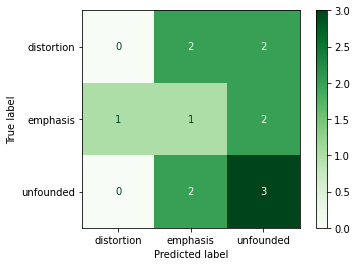

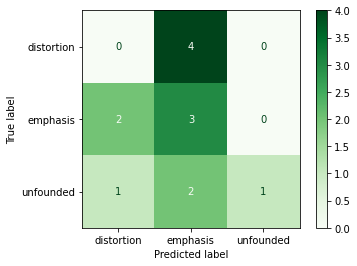

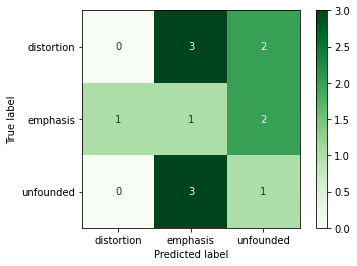

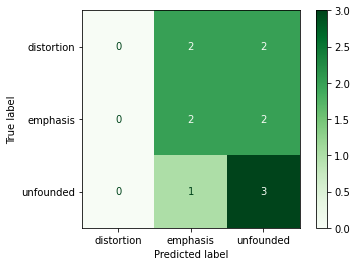

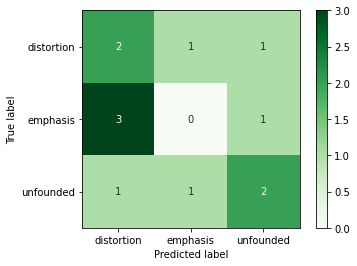

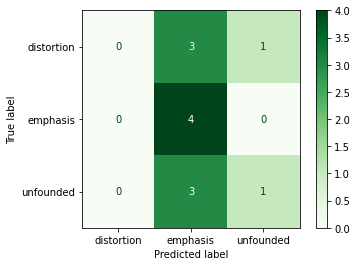

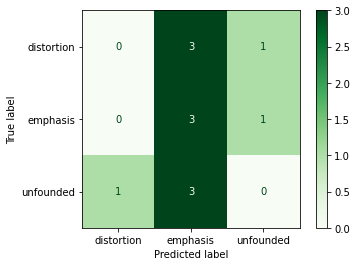

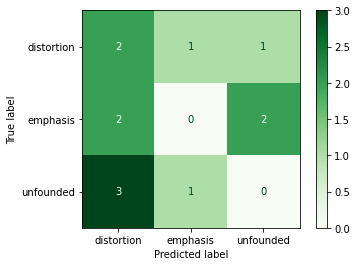

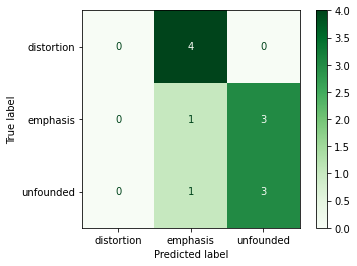

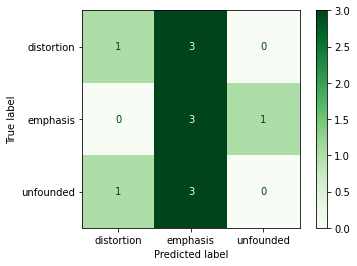

In [284]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Evaluation
randForestClass = RandomForestClassifier()
parameters = {
              'criterion':('gini', 'entropy'), 
              'max_features':('auto', 'sqrt', 'log2'),
              'n_estimators':[100, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
#               ,'max_depth': range(1,10)
             }
randForestClassifier = GridSearchCV(randForestClass, parameters, n_jobs = -1, cv=5, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(summarisationData, randForestClassifier)

# Random Forest Classification Method Tf-Idf
print("\n---- Tf-Idf Results----\n")
# randForestClas = RandomForestClassifier(n_estimators=1000, random_state=0)
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_TfIdf(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " MeanF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.27555555555555555
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.39
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.4766666666666667
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.43555555555555553
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3866666666666666
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3533333333333334
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3511111111111111
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3944444444444444
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.2833333333333333
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3344444444444445

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.23076923076923078
Iteration: 1  F1Macro  Score:  0.19528619528619529
-------------------------------------
Iteration: 2  Accuracy Score:  0.23076923076923078
Iteration: 2  F1Macro 

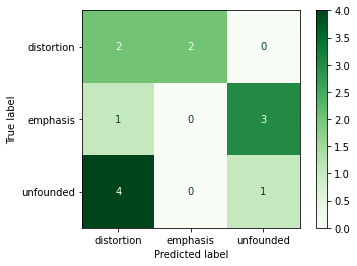

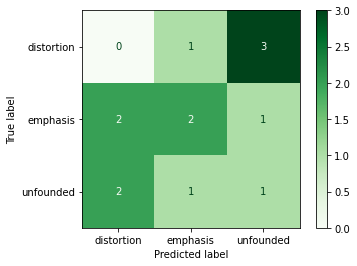

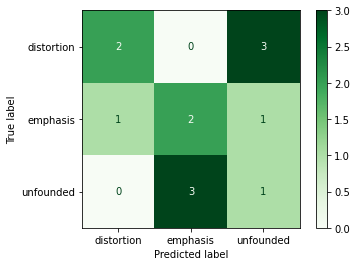

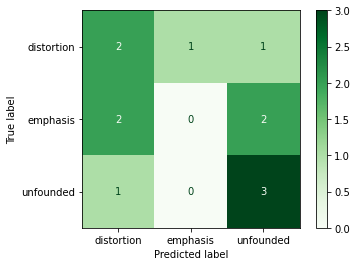

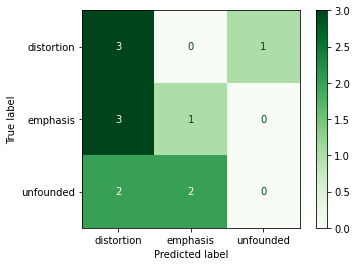

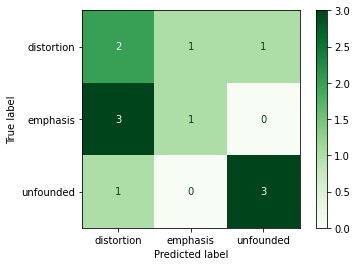

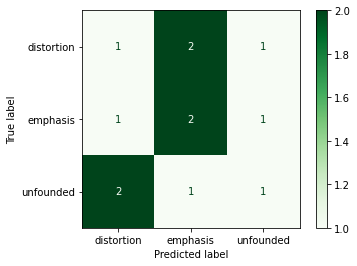

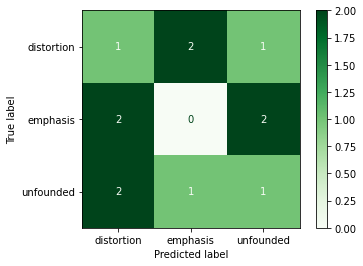

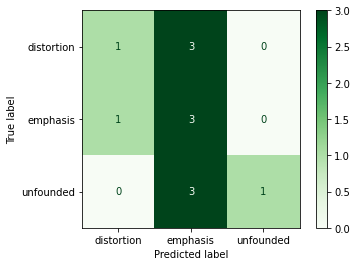

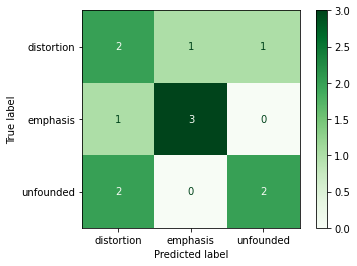

In [283]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Evaluation
randForestClass = RandomForestClassifier()
parameters = {
              'criterion':('gini', 'entropy'), 
              'max_features':('auto', 'sqrt', 'log2'),
              'n_estimators':[100, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
             }
randForestClassifier = GridSearchCV(randForestClass, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(summarisationData, randForestClassifier)

# Random Forest Classification Method

# Word2Vec
print("\n---- Word2Vec Results----\n")
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_Word2Vec(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score",meanF1Score)

Fold  1  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.40444444444444444
Fold  2  of tuning. F1Val:  0.5384615384615384  F1Kfold:  0.47444444444444434
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.4177777777777778
Fold  4  of tuning. F1Val:  0.5  F1Kfold:  0.39555555555555555
Fold  5  of tuning. F1Val:  0.5833333333333334  F1Kfold:  0.45777777777777773
Fold  6  of tuning. F1Val:  0.08333333333333333  F1Kfold:  0.4322222222222223
Fold  7  of tuning. F1Val:  0.5  F1Kfold:  0.40555555555555556
Fold  8  of tuning. F1Val:  0.25  F1Kfold:  0.47444444444444445
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.43555555555555553
Fold  10  of tuning. F1Val:  0.25  F1Kfold:  0.42444444444444446

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.31
Iteration: 1  MacroF1 Score:  0.26
-------------------------------------
Iteration: 2  Accuracy Score:  0.38
Iteration: 2  MacroF1 Score:  0.39
-------------------------------------
Iteration: 3  Accuracy Score:  0.

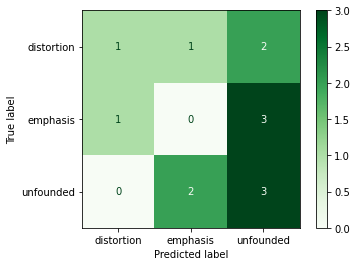

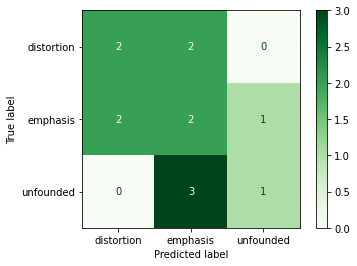

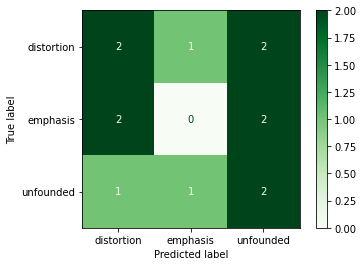

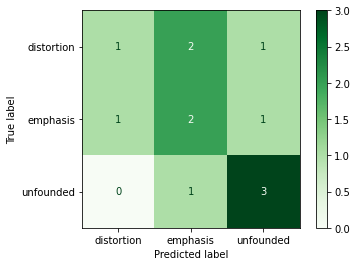

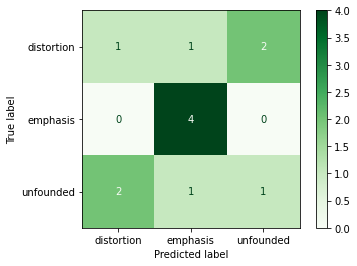

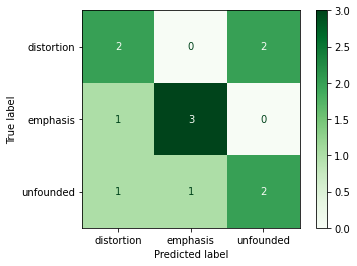

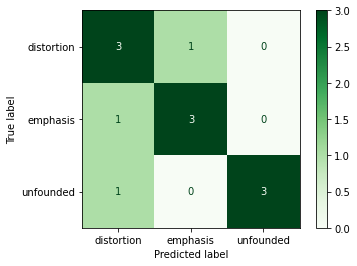

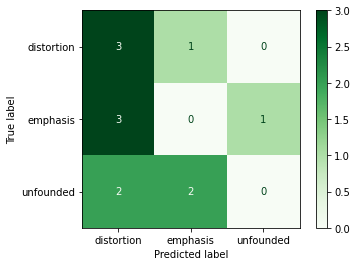

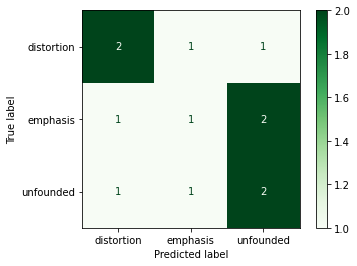

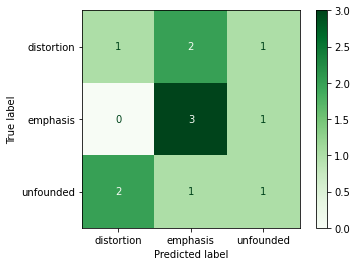

In [285]:
from sklearn.neighbors import KNeighborsClassifier

# # K-Neighbors Evaluation
kNeighborsClas = KNeighborsClassifier()
parameters = {
              'weights':('uniform', 'distance'), 
              'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
              'n_neighbors':range(1,50)
             }
kNClassifier = GridSearchCV(kNeighborsClas, parameters, n_jobs=-1, cv=10, scoring='accuracy')

bestModel, bestf1Val, bestKf1Val, bestParams = HyperParameterTuningTfIdf(summarisationData, kNClassifier)

# K-Neighbors Classifier Tf-Idf
print("\n---- Tf-Idf Results----\n")
accuracyArrayX, meanMacroF1, meanAccuracyX = TenFoldValidation_TfIdf(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " Mean F1Score: ", meanMacroF1)
print("Best Parameters for KNeighbours Classifier are: ",bestParams)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.40315789473684216
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.4542105263157895
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.4226315789473684
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4257894736842105
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4242105263157894
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4236842105263158
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.48473684210526324
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.49526315789473685
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4047368421052632
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.47631578947368425

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.23076923076923078
Iteration: 1  F1Macro  Score:  0.1851851851851852
-------------------------------------
Iteration: 2  Accuracy Score:  0.3076923076923077
Iteratio

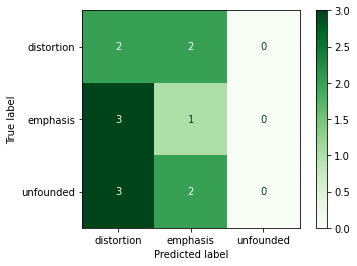

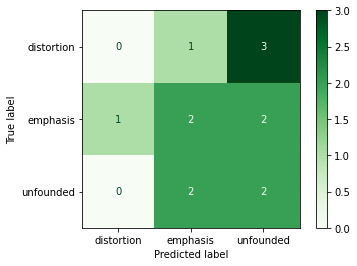

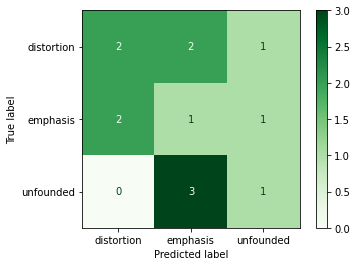

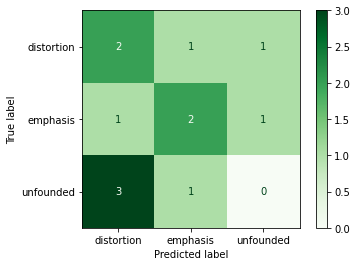

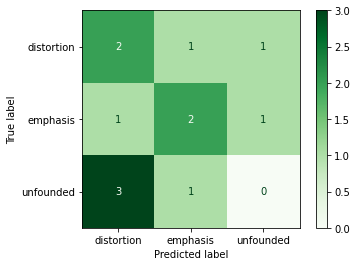

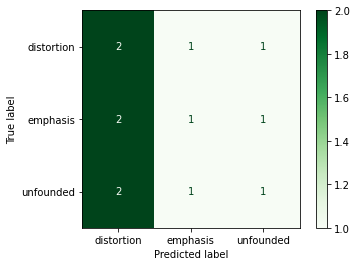

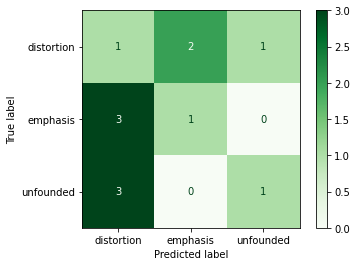

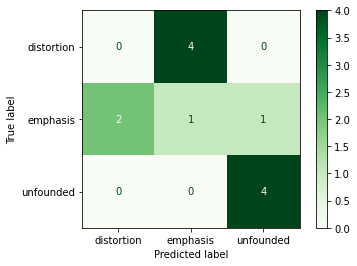

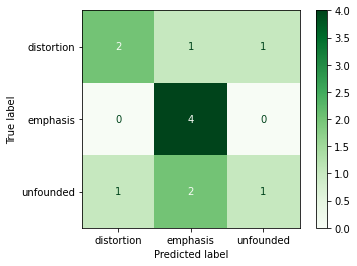

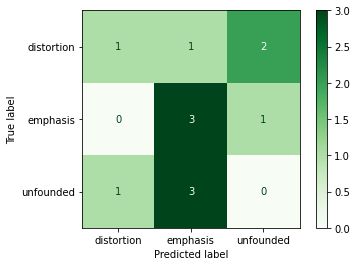

In [258]:
from sklearn.neighbors import KNeighborsClassifier

# K-Neighbors Evaluation
kNeighborsClas = KNeighborsClassifier()
parameters = {
              'weights':('uniform', 'distance'), 
              'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
              'n_neighbors':range(1,150)
             }
# kNClassifier = GridSearchCV(kNeighborsClas, parameters, n_jobs=-1, cv=5, scoring='f1_macro')
kNClassifier = GridSearchCV(kNeighborsClas, parameters, n_jobs=-1, cv=5, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(summarisationData, kNClassifier)

# K-Neighbors Classifier

print("\n---- Word2Vec Results----\n")
# # Word2Vec
accuracyArrayY, meanF1Score, meanAccuracyY = TenFoldValidation_Word2Vec(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score: ",meanF1Score)
print("KNeighoburs best parameters are: ",bestParams)

Fold  1  of tuning. F1Val:  0.5384615384615384  F1Kfold:  0.4022222222222222
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.40777777777777785
Fold  3  of tuning. F1Val:  0.6153846153846154  F1Kfold:  0.3733333333333333
Fold  4  of tuning. F1Val:  0.25  F1Kfold:  0.4033333333333333
Fold  5  of tuning. F1Val:  0.5  F1Kfold:  0.39555555555555555
Fold  6  of tuning. F1Val:  0.08333333333333333  F1Kfold:  0.4033333333333333
Fold  7  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.36444444444444446
Fold  8  of tuning. F1Val:  0.25  F1Kfold:  0.4333333333333333
Fold  9  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.4066666666666666
Fold  10  of tuning. F1Val:  0.25  F1Kfold:  0.3944444444444445

---- Bow - Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.54
Iteration: 1  MacroF1 Score:  0.53
-------------------------------------
Iteration: 2  Accuracy Score:  0.31
Iteration: 2  MacroF1 Score:  0.31
-------------------------------------
Iteration: 3  Accuracy Score:  

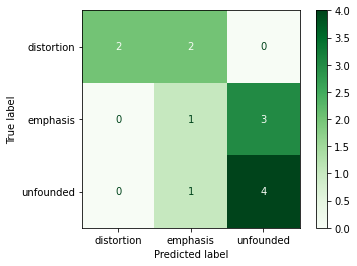

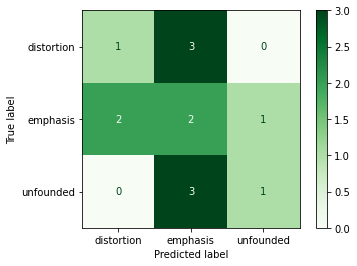

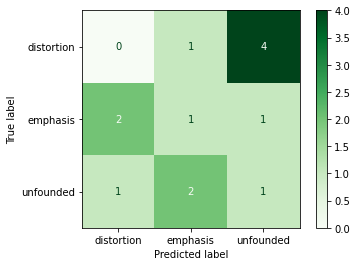

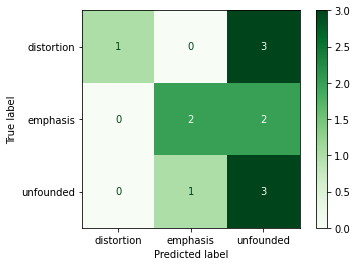

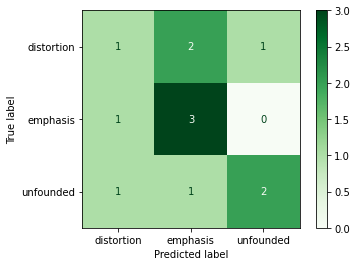

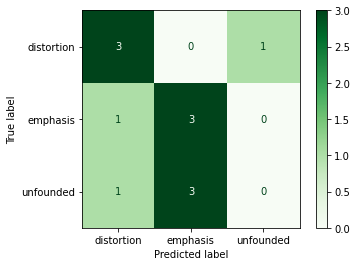

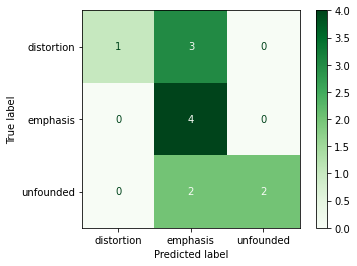

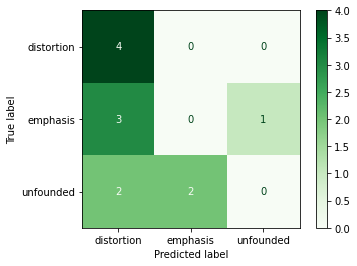

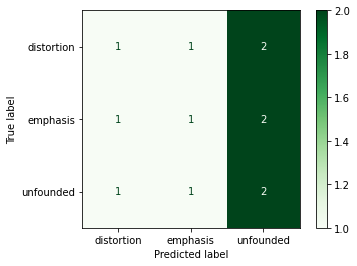

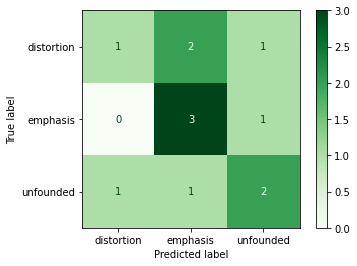

In [259]:
from sklearn.svm import SVC

# SVM Classifier Evaluation
svmClass = SVC()
parameters = {
                'kernel':('linear', 'rbf', 'poly', 'sigmoid'),
                'gamma': ('scale', 'auto'),
                'C': [0.001,0.01, 0.1, 1, 2, 10, 100]
             }
svmClassifier = GridSearchCV(svmClass, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestF1Val, bestKVal, bestParams = HyperParameterTuningTfIdf(summarisationData, svmClassifier)

# SVM Classifier

# Bow - Tf-Idf
print("\n---- Bow - Tf-Idf Results----\n")
svmClas = SVC()
accuracyArrayX, meanMacroF1, meanAccuracyX = TenFoldValidation_TfIdf(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, "Mean MacroF1: ", meanMacroF1)
print("Best SVC with Tf-Idf Parameters: ",bestParams)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.35
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.3
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.36000000000000004
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.2911111111111111
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.30333333333333334
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.31333333333333335
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3244444444444444
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3866666666666666
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.32333333333333336
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.33333333333333337

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.15384615384615385
Iteration: 1  F1Macro  Score:  0.1111111111111111
-------------------------------------
Iteration: 2  Accuracy Score:  0.38461538461538464
Iteration: 2  F1Macro  Score:  0.31

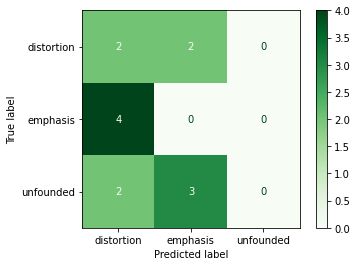

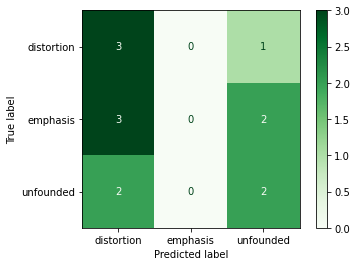

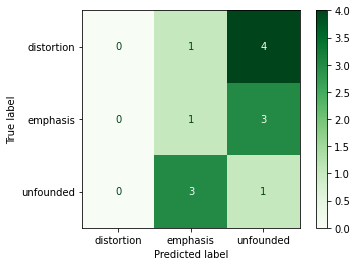

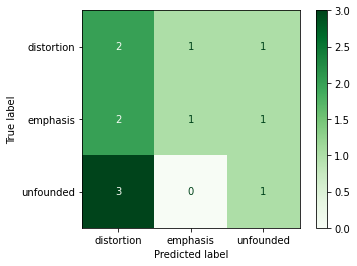

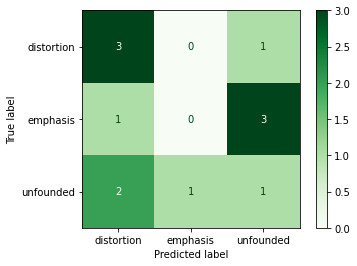

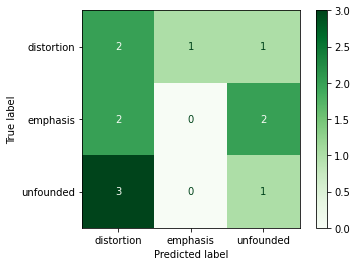

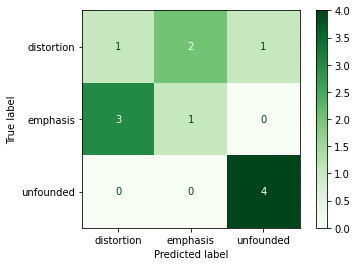

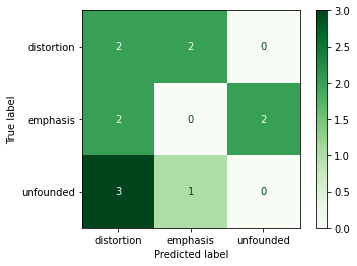

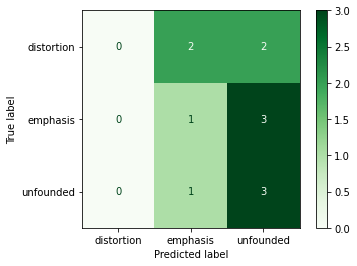

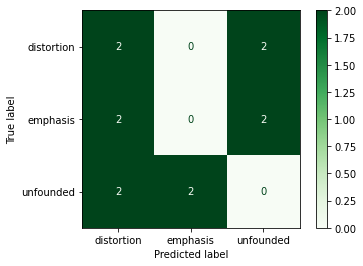

In [262]:
from sklearn.svm import SVC

# SVM Classifier Evaluation
svmClass = SVC()
parameters = {
                'kernel':('linear', 'rbf', 'poly', 'sigmoid'),
                'gamma': ('scale', 'auto'),
                'C': [0.01, 0.1, 1, 2, 10, 100]
             }
# svmClassifier = GridSearchCV(svmClass, parameters, n_jobs = -1, cv=10, scoring='f1_macro')
svmClassifier = GridSearchCV(svmClass, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(summarisationData, svmClassifier)

# SVM Classifier

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayY, meanF1Score, meanAccuracyY = TenFoldValidation_Word2Vec(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.6153846153846154  F1Kfold:  0.42333333333333334
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.4066666666666666
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.34555555555555556
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3244444444444444
Fold  5  of tuning. F1Val:  0.5  F1Kfold:  0.34555555555555556
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.37333333333333335
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.40555555555555556
Fold  8  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.4333333333333333
Fold  9  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.45777777777777784
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3544444444444445

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.46
Iteration: 1  MacroF1 Score:  0.45
-------------------------------------
Iteration: 2  Accuracy Score:  0.15
Iteration: 2  MacroF1 Score:  0.09
-------------------------------

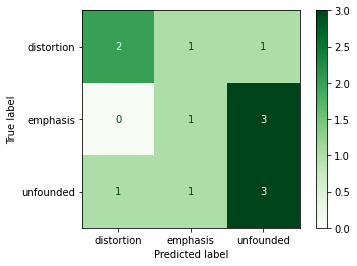

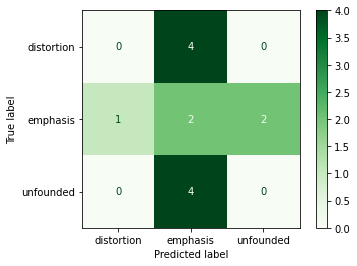

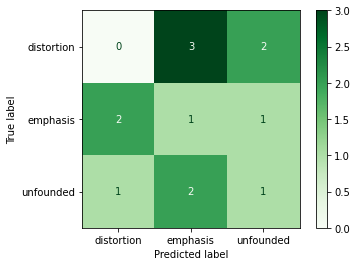

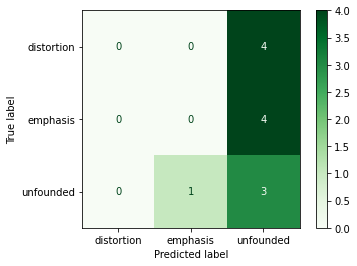

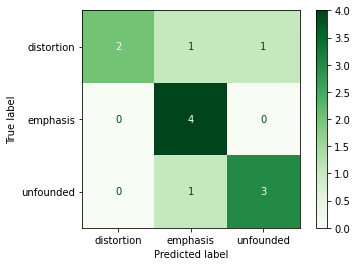

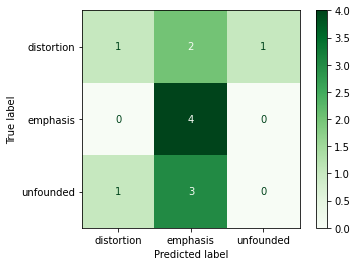

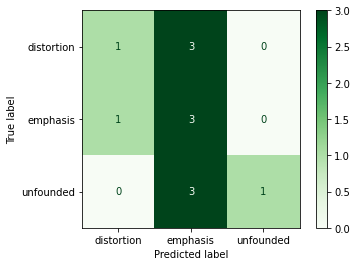

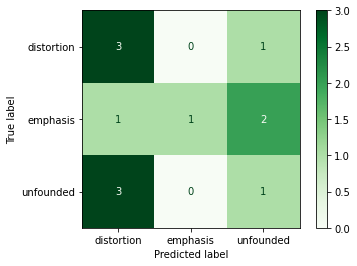

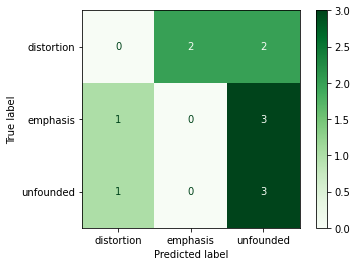

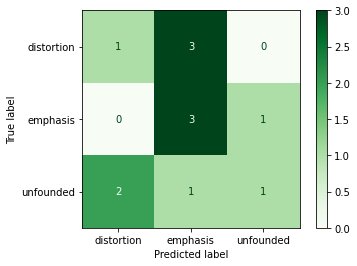

In [260]:
from sklearn.svm import LinearSVC

# Linear SVC Classifier Evaluation
linearSVC = LinearSVC()
parameters = {
                'loss': ('hinge', 'squared_hinge'),
                'multi_class': ('ovr', 'crammer_singer'),
                'C': [0.01, 0.1, 1.0, 2.0, 10.0, 100.0],
                'max_iter': [1000, 2000, 5000, 10000]
             }
linearSVCClassifier = GridSearchCV(linearSVC, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestF1Val, bestKVal, bestParams = HyperParameterTuningTfIdf(summarisationData, linearSVCClassifier)

# SVM Classifier Tf-Idf
print("\n---- Tf-Idf Results----\n")
accuracyArrayX, meanMacroF1, meanAccuracyX = TenFoldValidation_TfIdf(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " MeanMacroF1: ", meanMacroF1)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.39222222222222225
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.44000000000000006
Fold  3  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.47000000000000003
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4444444444444445
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.37444444444444447
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.39555555555555555
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.40444444444444444
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.42444444444444446
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4333333333333333
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.39333333333333337

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.3076923076923077
Iteration: 1  F1Macro  Score:  0.25396825396825395
-------------------------------------
Iteration: 2  Accuracy Score:  0.46153846153846156
It

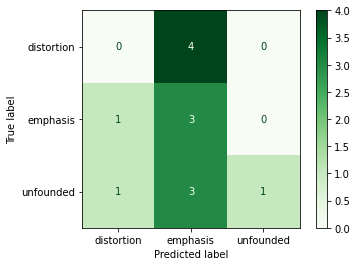

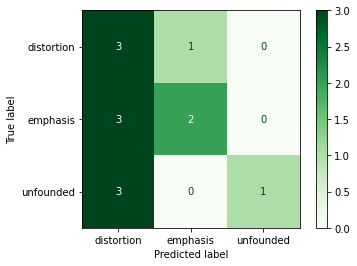

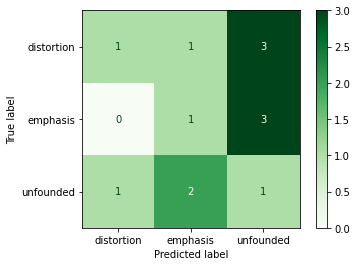

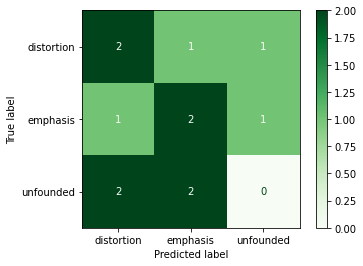

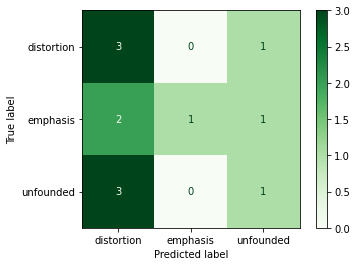

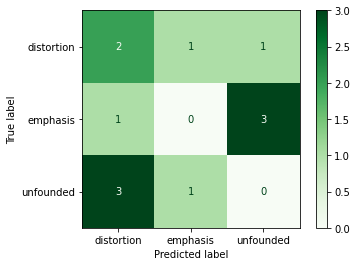

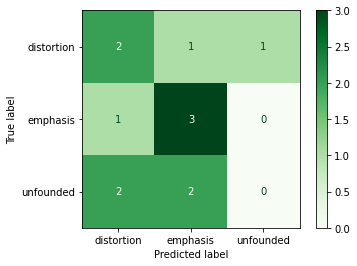

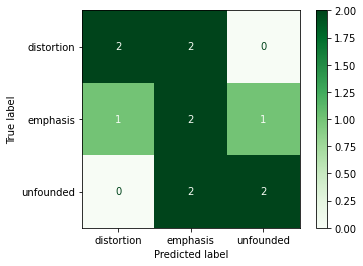

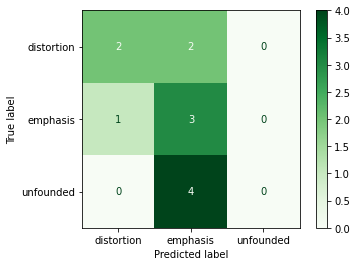

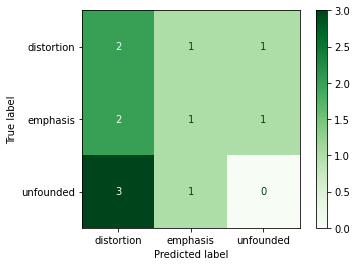

In [263]:
from sklearn.svm import LinearSVC

# Linear SVC Evaluation
linearSVC = LinearSVC()
parameters = {
                'loss': ('hinge', 'squared_hinge'),
                'multi_class': ('ovr', 'crammer_singer'),
                'C': [0.01, 0.1, 1.0, 2.0, 10.0, 100.0],
                'max_iter': [1000, 2000, 5000, 10000]
             }
linearSVCClassifier = GridSearchCV(linearSVC, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(summarisationData, linearSVCClassifier)

# Linear SVM Classifier

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayY, meanF1Score, meanAccuracyY = TenFoldValidation_Word2Vec(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.38111111111111107
Fold  2  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.37444444444444447
Fold  3  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.2911111111111111
Fold  4  of tuning. F1Val:  0.5  F1Kfold:  0.29333333333333333
Fold  5  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.3244444444444444
Fold  6  of tuning. F1Val:  0.25  F1Kfold:  0.35444444444444445
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.31444444444444447
Fold  8  of tuning. F1Val:  0.08333333333333333  F1Kfold:  0.34222222222222226
Fold  9  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.36444444444444446
Fold  10  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.31444444444444447

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.46
Iteration: 1  MacroF1 Score:  0.47
-------------------------------------
Iteration: 2  Accuracy Score:  0.23
Iteration: 2  MacroF1 Score:  0.19
-------------------------------------
I

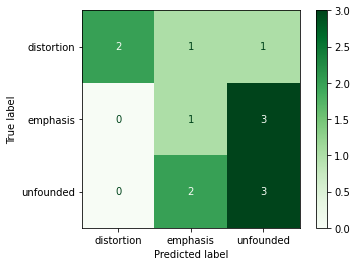

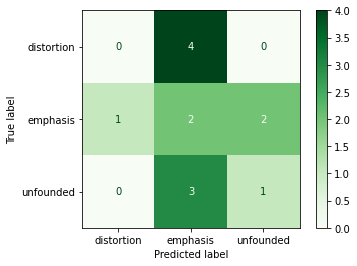

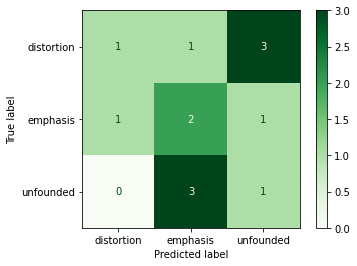

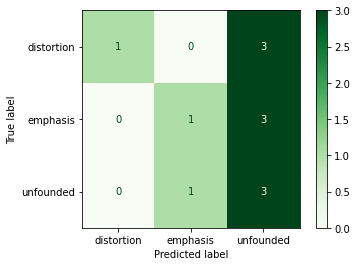

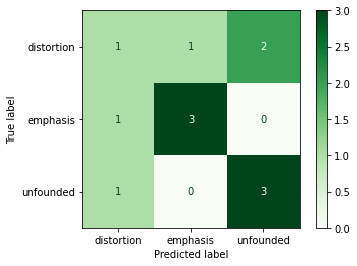

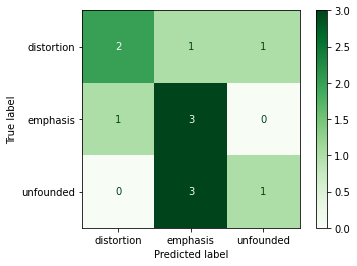

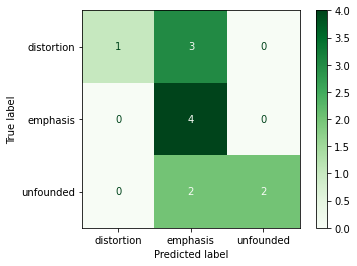

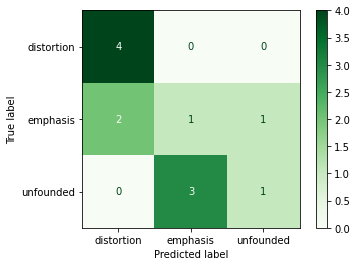

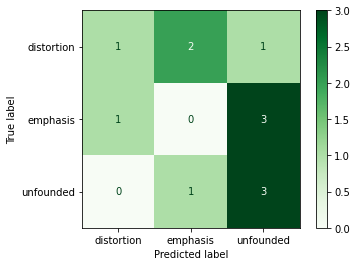

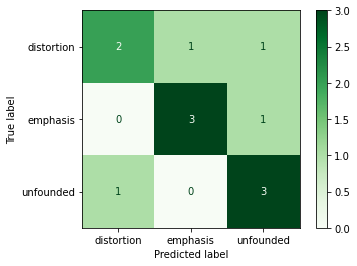

In [264]:
from sklearn.gaussian_process import GaussianProcessClassifier

# Gaussian Process Classifier Evaluation
gaussianProcClas = GaussianProcessClassifier()
parameters = {
                'multi_class': ('one_vs_rest', 'one_vs_one'),
                'max_iter_predict': [100, 200, 300, 400, 500]
             }
gaussianProcClassifier = GridSearchCV(gaussianProcClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestf1Val, bestKVal, bestParams = HyperParameterTuningTfIdf(summarisationData, gaussianProcClassifier)

# Gaussian Process Classifier Tf-Idf
print("\n---- Tf-Idf Results----\n")
# gaussianProcClas = GaussianProcessClassifier()
accuracyArrayX, meanMacroF1, meanAccuracyX = TenFoldValidation_TfIdf(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " MeanMacroF1: ", meanMacroF1)
print("Best Parameters for Gaussian Process Classifier: ",bestParams)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.39
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.35000000000000003
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.34
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.31444444444444447
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.25222222222222224
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.2844444444444445
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3044444444444444
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.29444444444444445
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3655555555555556
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.2733333333333333

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.23076923076923078
Iteration: 1  F1Macro  Score:  0.1851851851851852
-------------------------------------
Iteration: 2  Accuracy Score:  0.38461538461538464
Iteration: 2  F1Macro  Score:  0.31

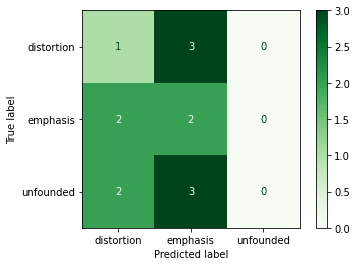

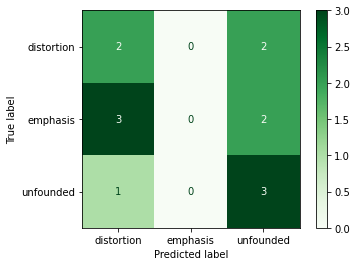

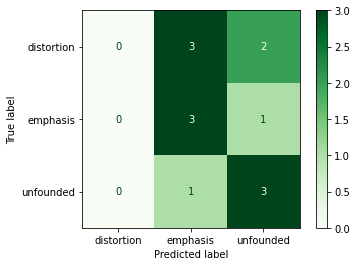

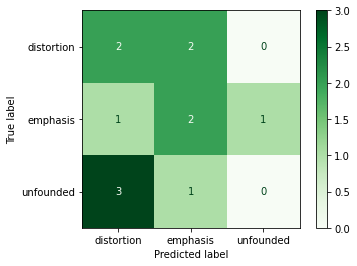

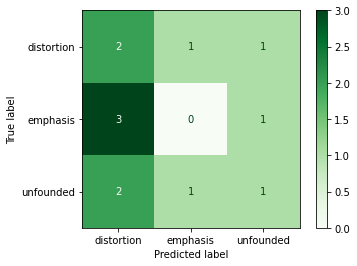

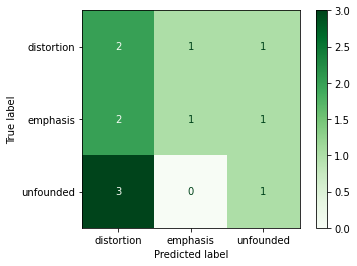

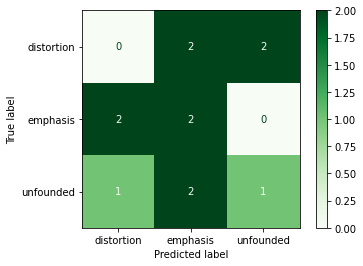

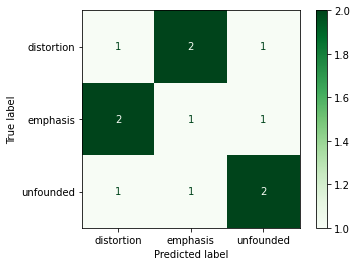

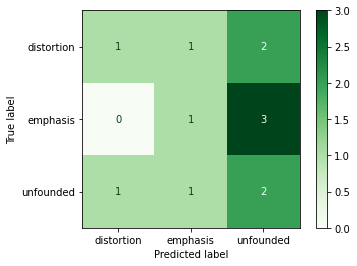

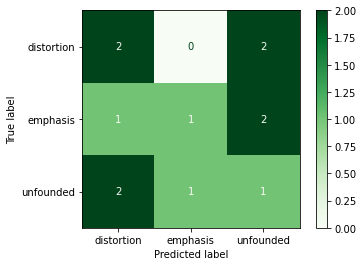

In [266]:
from sklearn.gaussian_process import GaussianProcessClassifier

# Gaussian Process Classifier Evaluation
gaussianProcClas = GaussianProcessClassifier()
parameters = {
                'multi_class': ('one_vs_rest', 'one_vs_one'),
                'max_iter_predict': [100, 200, 300, 400, 500]
             }
gaussianProcClassifier = GridSearchCV(gaussianProcClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(summarisationData, gaussianProcClassifier)

# Gaussian Process Classifier

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayY, meanF1Score, meanAccuracyY = TenFoldValidation_Word2Vec(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, "MeanF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.15384615384615385  F1Kfold:  0.4011111111111111
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.42333333333333334
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.45666666666666667
Fold  4  of tuning. F1Val:  0.5  F1Kfold:  0.4033333333333333
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3944444444444445
Fold  6  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.39555555555555555
Fold  7  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.4988888888888889
Fold  8  of tuning. F1Val:  0.25  F1Kfold:  0.4033333333333333
Fold  9  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.40444444444444444
Fold  10  of tuning. F1Val:  0.25  F1Kfold:  0.38555555555555554

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.23
Iteration: 1  MacroF1 Score:  0.21
-------------------------------------
Iteration: 2  Accuracy Score:  0.23
Iteration: 2  MacroF1 Score:  0.2
-------------------------------------
Iteration: 3  Accura

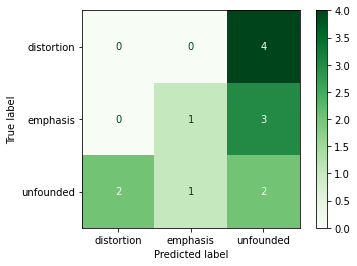

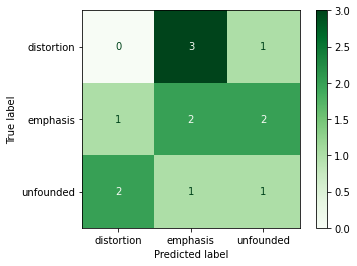

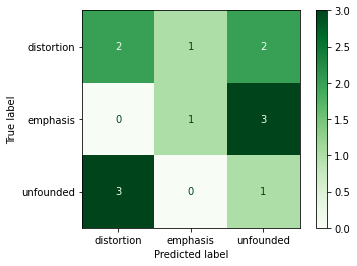

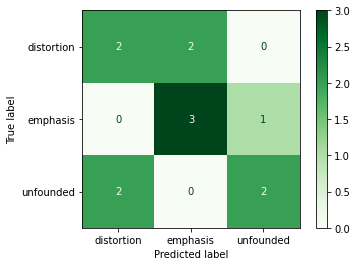

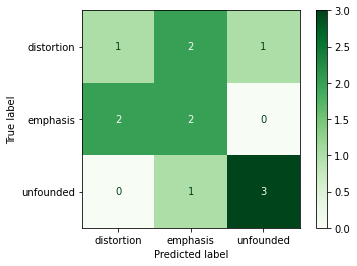

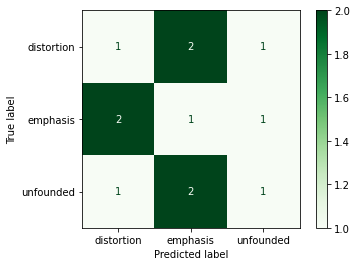

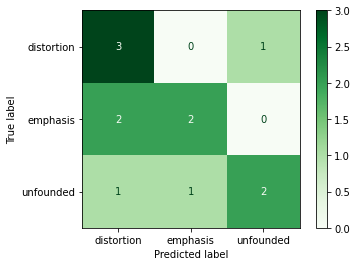

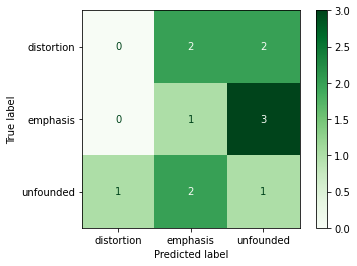

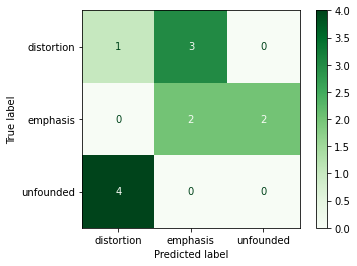

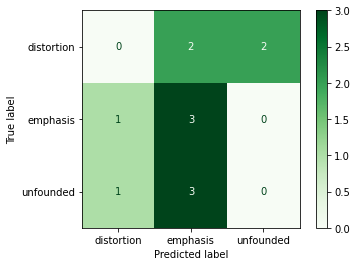

In [267]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier Evaluation

decisionTreeClas = DecisionTreeClassifier()
parameters = {
                'criterion': ('gini', 'entropy'),
                'splitter': ('best', 'random'),
                'max_features':  ('auto', 'sqrt', 'log2', 'None')
             }
decisionTreeClassifier = GridSearchCV(decisionTreeClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestf1Val, bestKVal, bestParams = HyperParameterTuningTfIdf(summarisationData, decisionTreeClassifier)

# Decision Tree Classifier Tf-Idf
print("\n---- Tf-Idf Results----\n")
decisionTreeClas = DecisionTreeClassifier()
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_TfIdf(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " Mean MacroF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.3911111111111111
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.3911111111111111
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.3844444444444444
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4311111111111111
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.43555555555555553
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3844444444444445
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3733333333333334
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4533333333333333
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3844444444444444
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4111111111111111

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.3076923076923077
Iteration: 1  F1Macro  Score:  0.29978354978354976
-------------------------------------
Iteration: 2  Accuracy Score:  0.23076923076923078
Iteration:

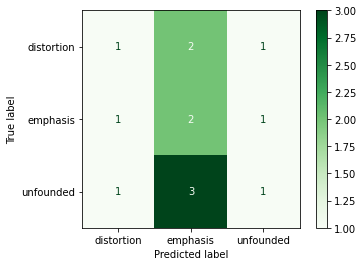

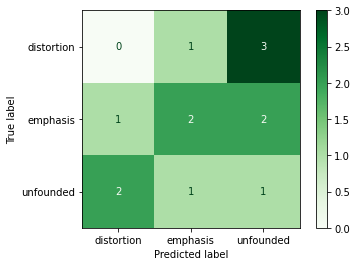

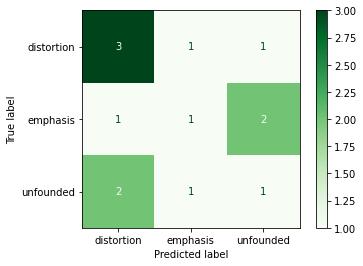

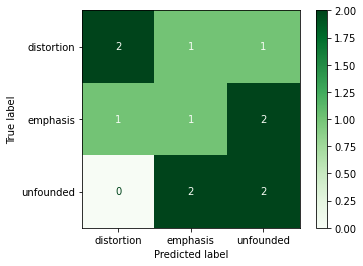

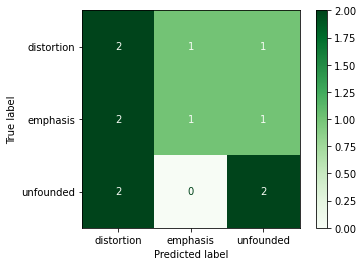

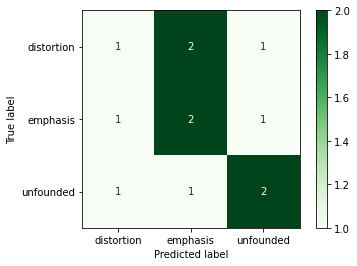

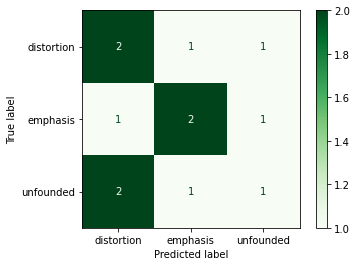

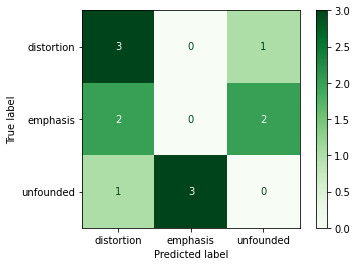

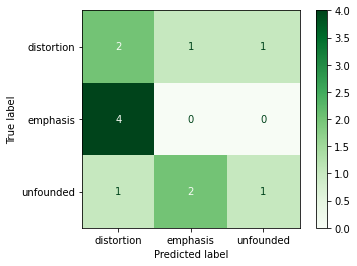

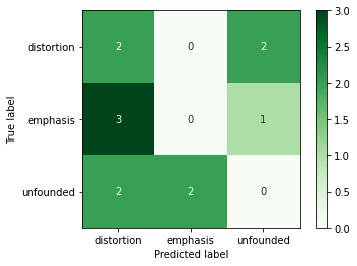

In [269]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier Evaluation

decisionTreeClas = DecisionTreeClassifier()
parameters = {
                'criterion': ('gini', 'entropy'),
                'splitter': ('best', 'random'),
                'max_features':  ('auto', 'sqrt', 'log2', 'None')
             }
decisionTreeClassifier = GridSearchCV(decisionTreeClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(summarisationData, decisionTreeClassifier)

# Decision Tree Classifier

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayY, meanF1Score, meanAccuracyY = TenFoldValidation_Word2Vec(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, "MeanF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.36444444444444446
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.39555555555555555
Fold  3  of tuning. F1Val:  0.23076923076923078  F1Kfold:  0.4177777777777777
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3155555555555556
Fold  5  of tuning. F1Val:  0.5  F1Kfold:  0.4666666666666667
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4144444444444444
Fold  7  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.39222222222222225
Fold  8  of tuning. F1Val:  0.5  F1Kfold:  0.4333333333333333
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.37333333333333335
Fold  10  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.3933333333333334

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.54
Iteration: 1  MacroF1 Score:  0.45
-------------------------------------
Iteration: 2  Accuracy Score:  0.31
Iteration: 2  MacroF1 Score:  0.32
-------------------------------------
Iteratio

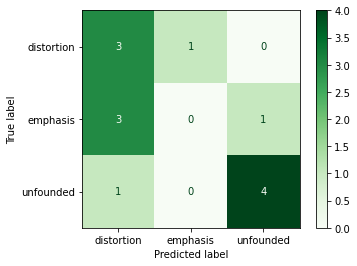

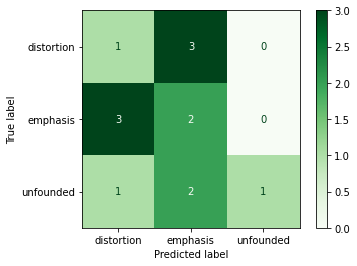

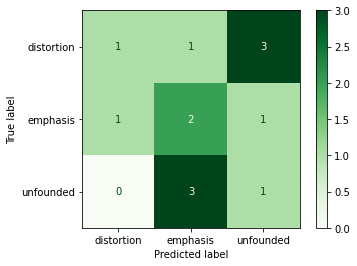

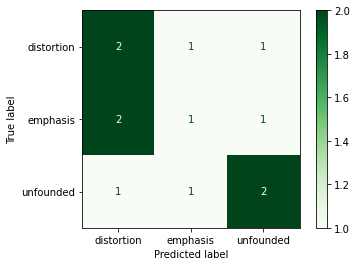

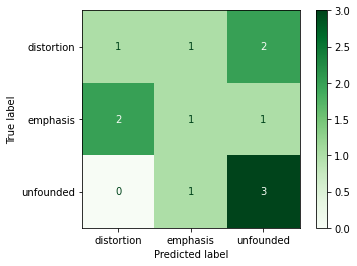

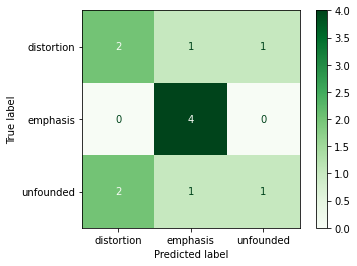

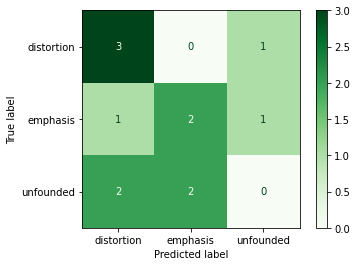

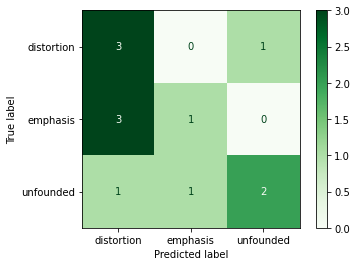

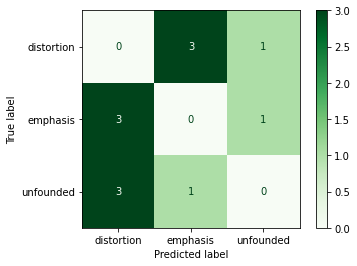

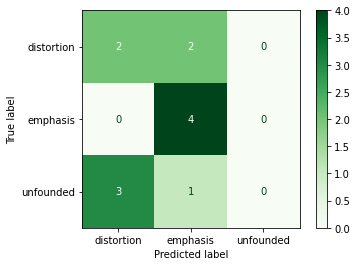

In [270]:
from sklearn.ensemble import AdaBoostClassifier

# Ada Boost Classifier Evaluation

adaBoostClas = AdaBoostClassifier()
parameters = {
                'n_estimators':  [10, 50, 100, 150, 200, 250, 300]
             }
adaBoostClassifier = GridSearchCV(adaBoostClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestF1Val, bestKVal, bestParams = HyperParameterTuningTfIdf(summarisationData, adaBoostClassifier)

# Ada Boost Classifier Tf-Idf
print("\n---- Tf-Idf Results----\n")
adaBoostClas = AdaBoostClassifier()
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_TfIdf(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " Mean MacroF1Score: ",meanF1Score)
print("Best Parameters for AdaBoost are: ",bestParams)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.25842105263157894
Fold  2  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.3178947368421053
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.4121052631578948
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.38368421052631574
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.35368421052631577
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.41368421052631577
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3636842105263158
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4457894736842105
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.37368421052631584
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.40421052631578946

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.38461538461538464
Iteration: 1  F1Macro  Score:  0.38311688311688313
-------------------------------------
Iteration: 2  Accuracy Score:  0.3076923076923077
Iter

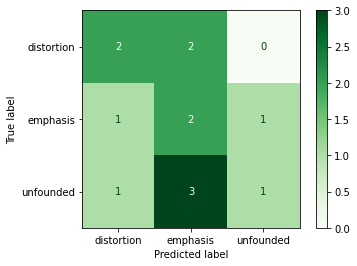

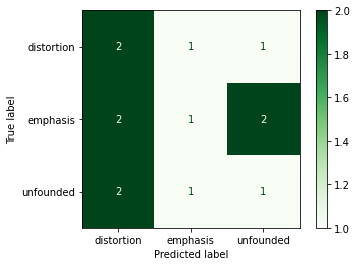

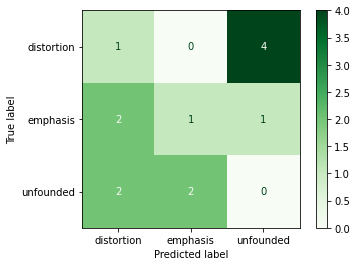

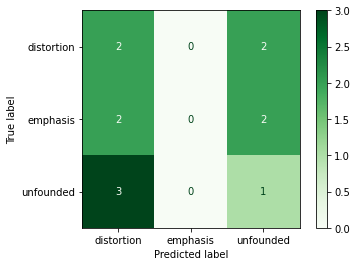

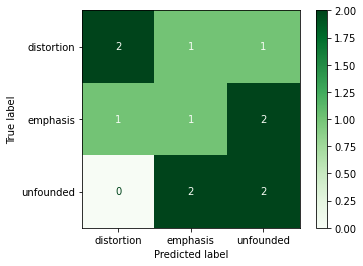

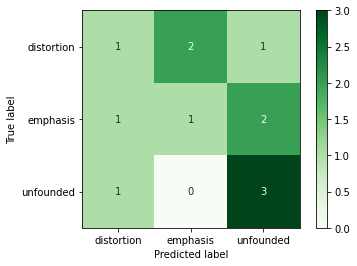

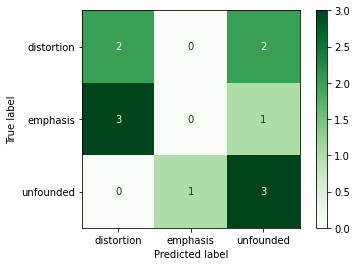

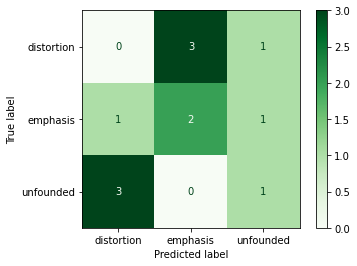

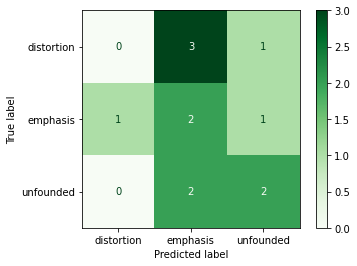

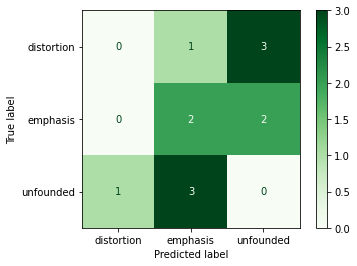

In [271]:
from sklearn.ensemble import AdaBoostClassifier

# Ada Boost Classifier Evaluation

adaBoostClas = AdaBoostClassifier()
parameters = {
                'n_estimators':  [50, 100, 150, 200]
             }
adaBoostClassifier = GridSearchCV(adaBoostClas, parameters, n_jobs = -1, cv=5, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(summarisationData, adaBoostClassifier)

# Ada Boost Classifier

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayY, meanF1Score, meanAccuracyY = TenFoldValidation_Word2Vec(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score: ", meanF1Score)

Fold  1  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.33999999999999997
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.3666666666666667
Fold  3  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.27111111111111114
Fold  4  of tuning. F1Val:  0.5  F1Kfold:  0.2833333333333333
Fold  5  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.32555555555555554
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.2922222222222222
Fold  7  of tuning. F1Val:  0.5  F1Kfold:  0.32555555555555554
Fold  8  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.28222222222222226
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.38555555555555554
Fold  10  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.2733333333333334

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.38
Iteration: 1  MacroF1 Score:  0.4
-------------------------------------
Iteration: 2  Accuracy Score:  0.31
Iteration: 2  MacroF1 Score:  0.31
-------------------------------------
Iterati

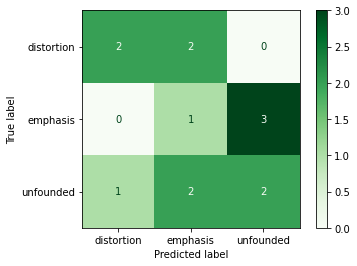

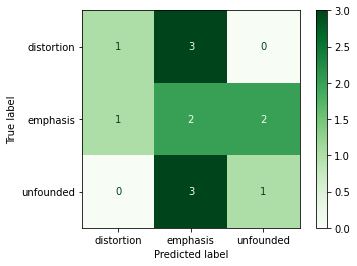

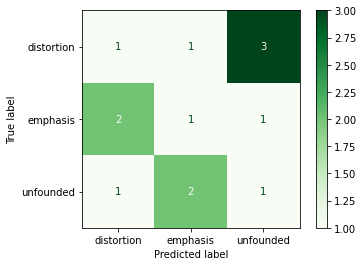

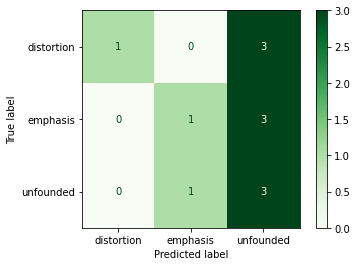

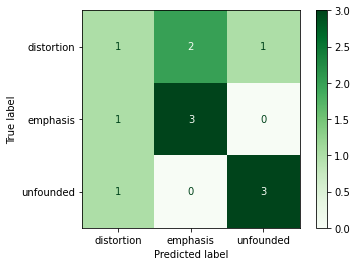

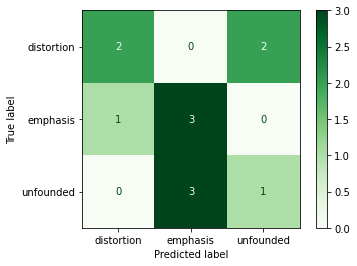

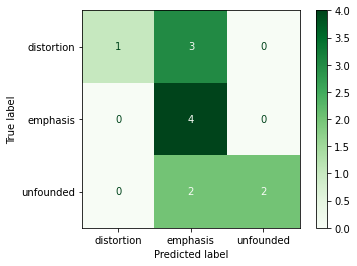

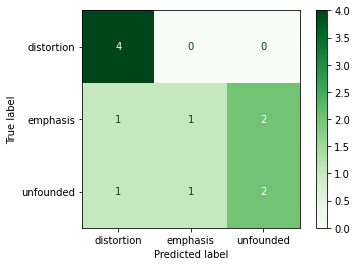

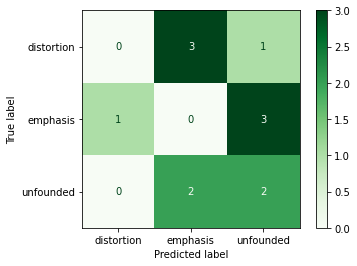

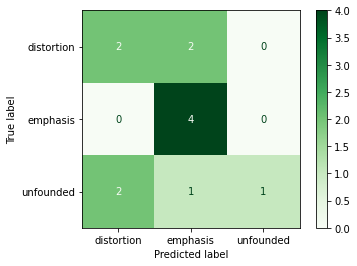

In [272]:
from sklearn.naive_bayes import MultinomialNB

# Multinomial Naive Bayes Classifier
multiNBClas = MultinomialNB()
parameters = {
                'alpha': [1, 0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
             }
multiNBClassifier = GridSearchCV(multiNBClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestF1Val, bestKVal, bestParams = HyperParameterTuningTfIdf(summarisationData, multiNBClassifier)

# Tf-Idf
print("\n---- Tf-Idf Results----\n")
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_TfIdf(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " MeanMacroF1Score: ", meanF1Score)
print("Best Params for MultinomialNB are: ",bestParams)

Fold  1  of tuning. F1Val:  0.46153846153846156  F1Kfold:  0.4344444444444444
Fold  2  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.4655555555555555
Fold  3  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.4455555555555555
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.45444444444444454
Fold  5  of tuning. F1Val:  0.5  F1Kfold:  0.4255555555555556
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.44222222222222224
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4344444444444444
Fold  8  of tuning. F1Val:  0.08333333333333333  F1Kfold:  0.5022222222222222
Fold  9  of tuning. F1Val:  0.25  F1Kfold:  0.4766666666666667
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.4255555555555556

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.38
Iteration: 1  MacroF1 Score:  0.37
-------------------------------------
Iteration: 2  Accuracy Score:  0.15
Iteration: 2  MacroF1 Score:  0.09
-------------------------------------
Iteration

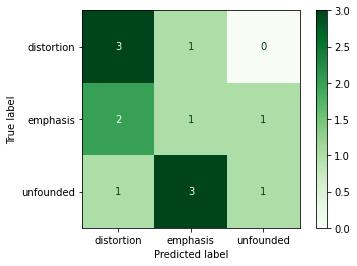

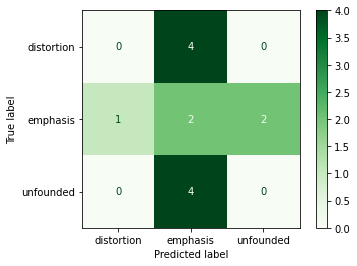

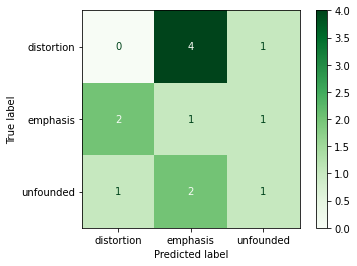

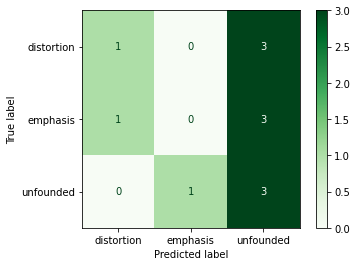

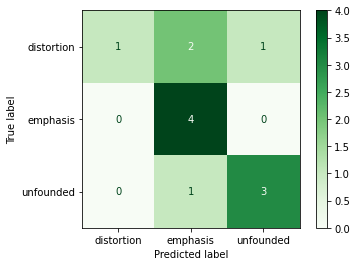

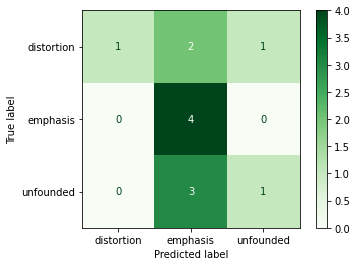

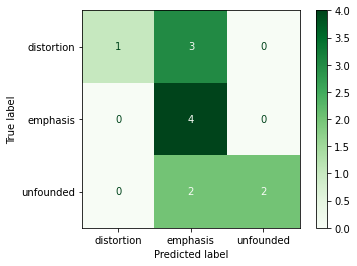

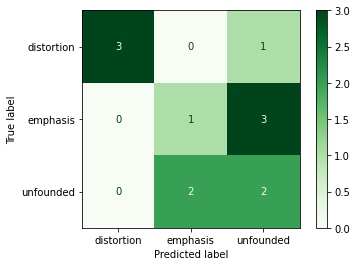

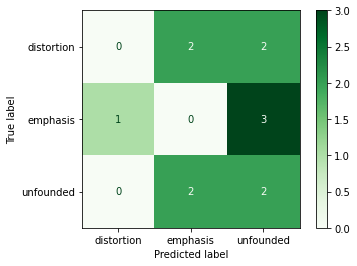

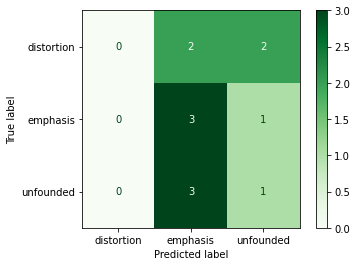

In [273]:
from sklearn.linear_model import SGDClassifier

# SGD Classifier

sgdClas = SGDClassifier()
parameters = {
                'penalty': ('l2', 'l1', 'elasticnet'),
                'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                'max_iter' : [500, 1000, 10000],
                'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                'n_iter_no_change': [5, 10, 15, 20],
                'early_stopping': (True, False)
             }
sgdClassifier = GridSearchCV(sgdClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestF1Val, bestKVal, bestParams = HyperParameterTuningTfIdf(summarisationData, sgdClassifier)

# Tf-Idf
print("\n---- Tf-Idf Results----\n")
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_TfIdf(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " MeanF1Score: ", meanF1Score)

Fold  1  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.3173372923372923
Fold  2  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.3027992377992378
Fold  3  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.2991484441484441
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3964041514041514
Fold  5  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.31515669515669514
Fold  6  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.27608872608872603
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.29577533577533577
Fold  8  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.30233026233026233
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3239051689051689
Fold  10  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.24748880748880753

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.38461538461538464
Iteration: 1  F1Macro  Score:  0.1851851851851852
-------------------------------------
Iteration: 2  Accuracy Score:  0.3076923076923077
Iter

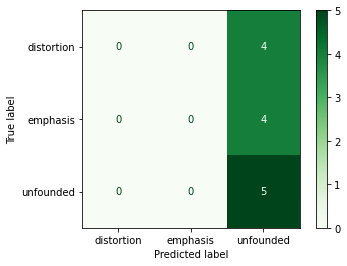

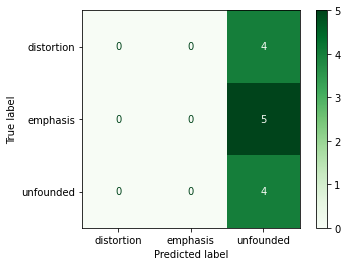

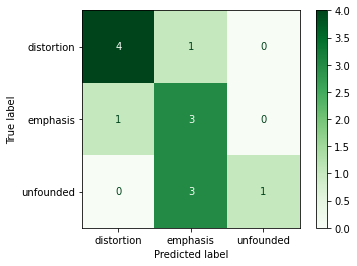

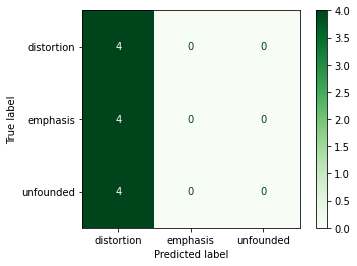

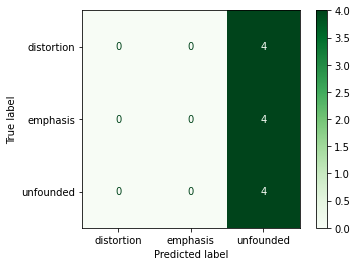

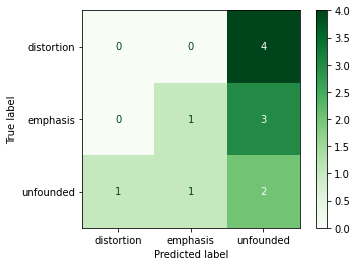

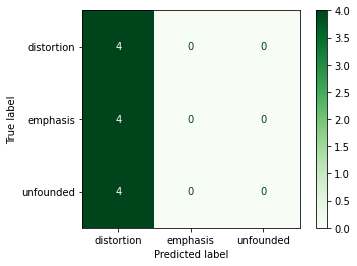

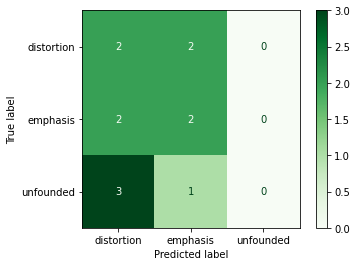

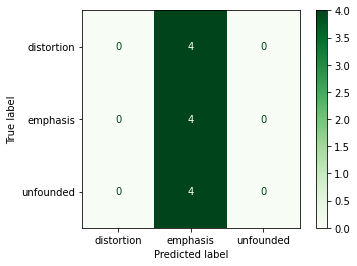

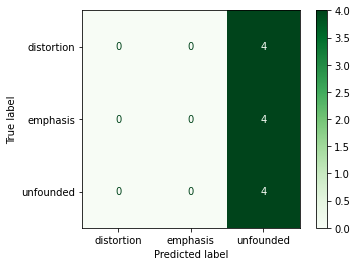

In [282]:
from sklearn.linear_model import SGDClassifier

# SGD Classifier

sgdClas = SGDClassifier()
parameters = {
                'penalty': ('l2', 'l1', 'elasticnet'),
                'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                'max_iter' : [500, 1000, 10000],
                'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
                'n_iter_no_change': [5, 10, 15, 20],
                'early_stopping': (True, False)
             }
sgdClassifier = GridSearchCV(sgdClas, parameters, n_jobs = -1, cv=10, scoring='f1_macro')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningWord2Vec(summarisationData, sgdClassifier)

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayY, meanF1Score, meanAccuracyY = TenFoldValidation_Word2Vec(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score: ",meanF1Score)

Fold  1  of tuning. F1Val:  0.6153846153846154  F1Kfold:  0.3633333333333333
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.40777777777777774
Fold  3  of tuning. F1Val:  0.46153846153846156  F1Kfold:  0.28222222222222226
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.31222222222222223
Fold  5  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.3144444444444444
Fold  6  of tuning. F1Val:  0.25  F1Kfold:  0.35222222222222227
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.29333333333333333
Fold  8  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.4133333333333333
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3966666666666666
Fold  10  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.30555555555555564

---- Bow - Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.54
Iteration: 1  MacroF1 Score:  0.52
-------------------------------------
Iteration: 2  Accuracy Score:  0.23
Iteration: 2  MacroF1 Score:  0.19
-----------------------

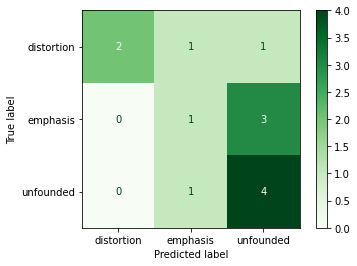

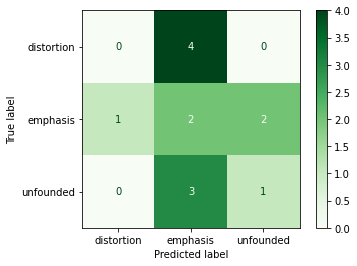

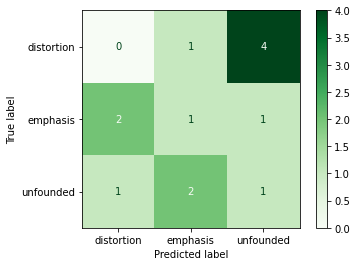

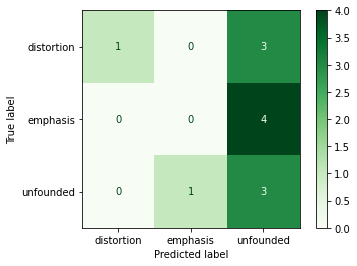

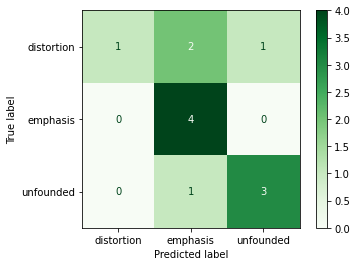

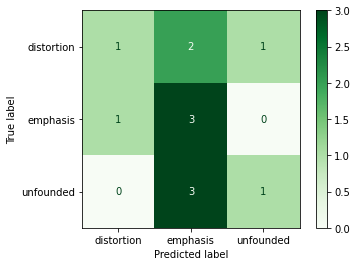

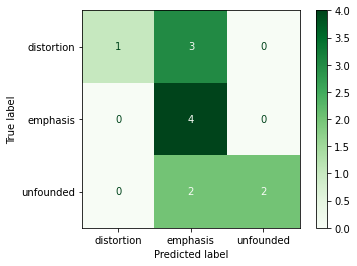

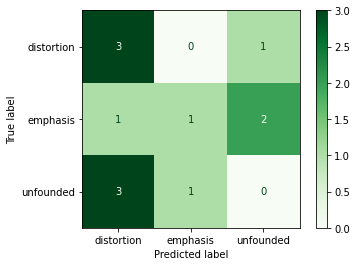

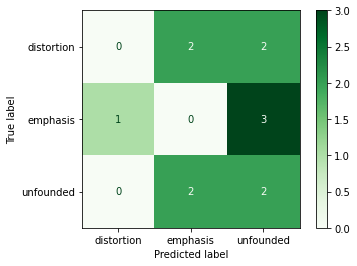

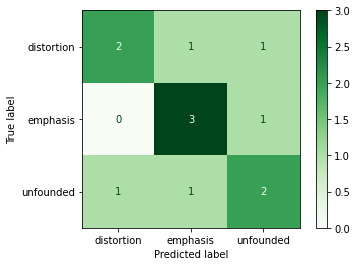

In [275]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression Evaluation

logRegClas = LogisticRegression(multi_class='ovr')
parameters = {
                'penalty': ('l2', 'none'),
                'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
                'max_iter': [100, 200, 500, 1000]
             }
logRegClassifier = GridSearchCV(logRegClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(summarisationData, logRegClassifier)

# Logistic Regression

# Bow - Tf-Idf
print("\n---- Bow - Tf-Idf Results----\n")
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_TfIdf(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " MeanF1Score: ",meanF1Score)
print("Best parameters for logistic regression are: ",bestParams)

Fold  1  of tuning. F1Val:  0.6153846153846154  F1Kfold:  0.3633333333333333
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.40777777777777774
Fold  3  of tuning. F1Val:  0.46153846153846156  F1Kfold:  0.28222222222222226
Fold  4  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.31222222222222223
Fold  5  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.3144444444444444
Fold  6  of tuning. F1Val:  0.25  F1Kfold:  0.35222222222222227
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.29333333333333333
Fold  8  of tuning. F1Val:  0.16666666666666666  F1Kfold:  0.4133333333333333
Fold  9  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3966666666666666
Fold  10  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.30555555555555564

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.3076923076923077
Iteration: 1  F1Macro  Score:  0.2558922558922559
-------------------------------------
Iteration: 2  Accuracy Score:  0.38461538461538464
Iteration: 2  F1Ma

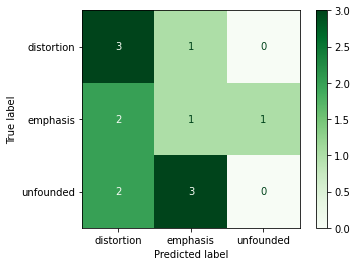

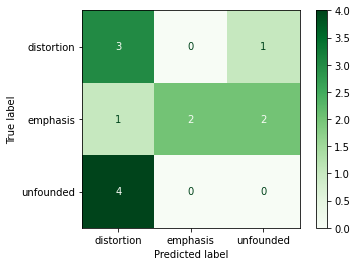

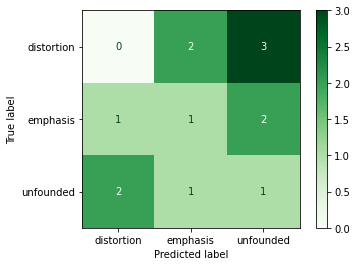

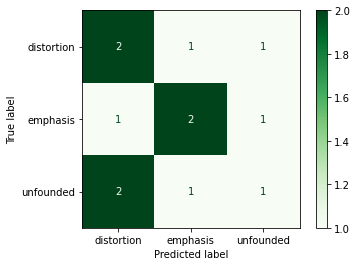

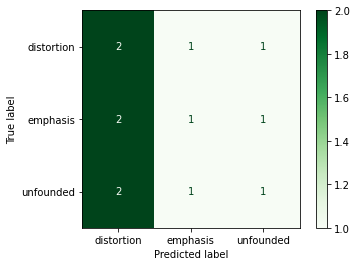

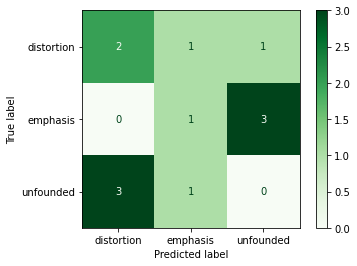

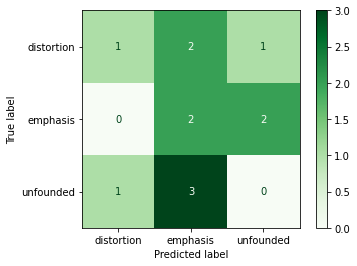

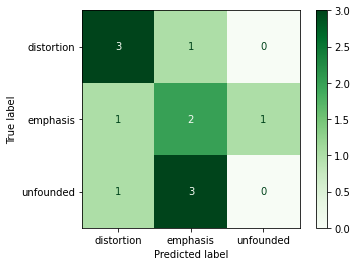

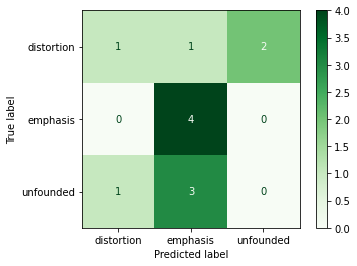

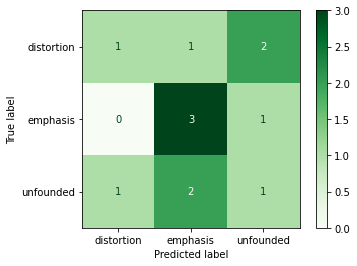

In [277]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression Evaluation

logRegClas = LogisticRegression(multi_class='ovr')
parameters = {
                'penalty': ('l2', 'none'),
                'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
                'max_iter': [100, 200, 500, 1000]
             }
logRegClassifier = GridSearchCV(logRegClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(summarisationData, logRegClassifier)

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayX, meanF1Score,meanAccuracyX = TenFoldValidation_Word2Vec(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score",meanF1Score)

Fold  1  of tuning. F1Val:  0.46153846153846156  F1Kfold:  0.39444444444444443
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.4066666666666666
Fold  3  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.32222222222222224
Fold  4  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.32222222222222224
Fold  5  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.34444444444444444
Fold  6  of tuning. F1Val:  0.25  F1Kfold:  0.4033333333333333
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.3044444444444444
Fold  8  of tuning. F1Val:  0.08333333333333333  F1Kfold:  0.4333333333333333
Fold  9  of tuning. F1Val:  0.25  F1Kfold:  0.4255555555555556
Fold  10  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.3244444444444444

---- Tf-Idf Results----

Iteration: 1  Accuracy Score:  0.54
Iteration: 1  MacroF1 Score:  0.52
-------------------------------------
Iteration: 2  Accuracy Score:  0.23
Iteration: 2  MacroF1 Score:  0.19
-------------------------------------
Iterat

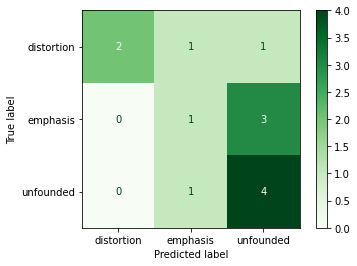

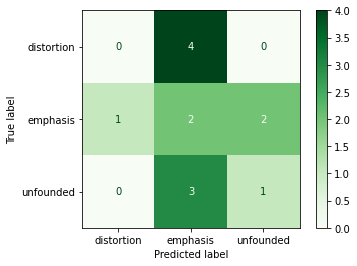

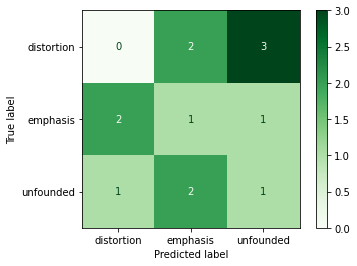

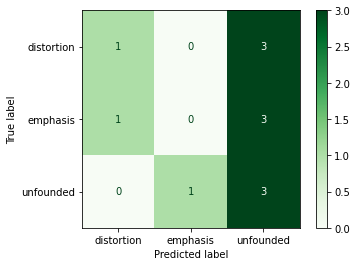

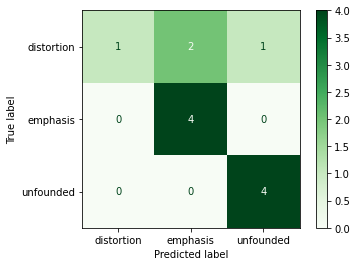

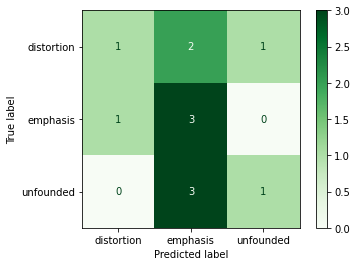

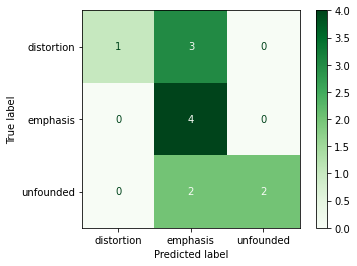

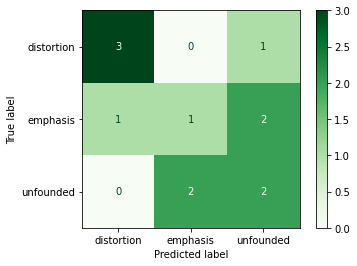

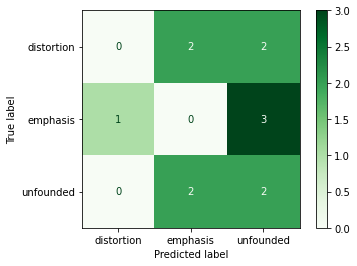

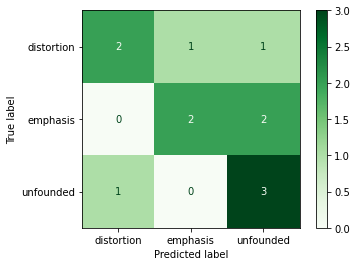

In [278]:
from sklearn.linear_model import RidgeClassifier

# Ridge Classifier Evaluation

ridgeClas = RidgeClassifier()
parameters = {
                'alpha': [0.05, 0.1, 0.5, 1, 2, 5, 10, 20],
                'tol' : [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                'solver': ('auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs')
             }
ridgeClassifier = GridSearchCV(ridgeClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(summarisationData, ridgeClassifier)

# Logistic Regression Tf-Idf
print("\n---- Tf-Idf Results----\n")
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_TfIdf(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyX, " MeanF1Score: ",meanF1Score)
print("Best parameters for Ridge Classifier are: ",bestParams)

Fold  1  of tuning. F1Val:  0.46153846153846156  F1Kfold:  0.39444444444444443
Fold  2  of tuning. F1Val:  0.3076923076923077  F1Kfold:  0.4066666666666666
Fold  3  of tuning. F1Val:  0.38461538461538464  F1Kfold:  0.32222222222222224
Fold  4  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.32222222222222224
Fold  5  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.3355555555555556
Fold  6  of tuning. F1Val:  0.25  F1Kfold:  0.39222222222222225
Fold  7  of tuning. F1Val:  0.3333333333333333  F1Kfold:  0.32333333333333336
Fold  8  of tuning. F1Val:  0.08333333333333333  F1Kfold:  0.4333333333333333
Fold  9  of tuning. F1Val:  0.25  F1Kfold:  0.4055555555555556
Fold  10  of tuning. F1Val:  0.4166666666666667  F1Kfold:  0.32555555555555554

---- Word2Vec Results----

Iteration: 1  Accuracy Score:  0.15384615384615385
Iteration: 1  F1Macro  Score:  0.1272727272727273
-------------------------------------
Iteration: 2  Accuracy Score:  0.3076923076923077
Iteration: 2  F1Macro  Score:  

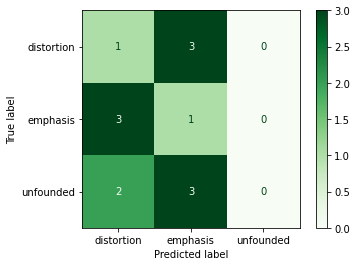

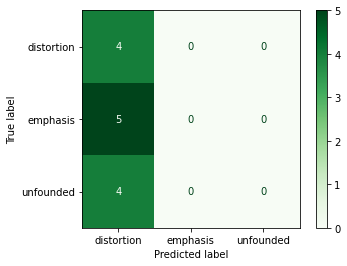

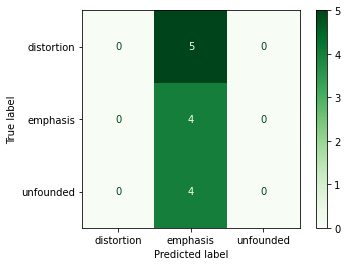

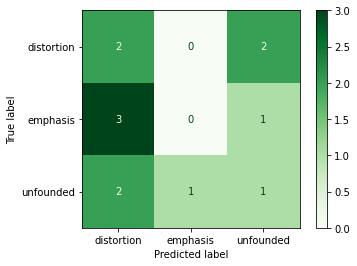

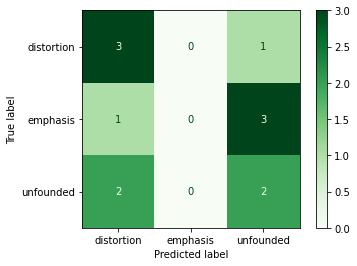

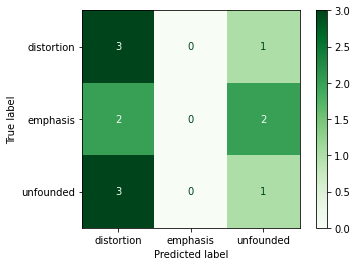

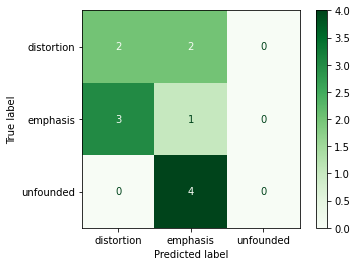

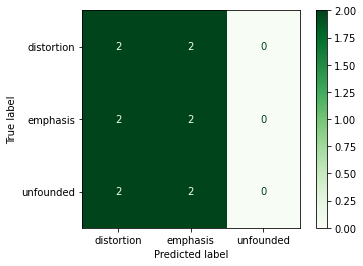

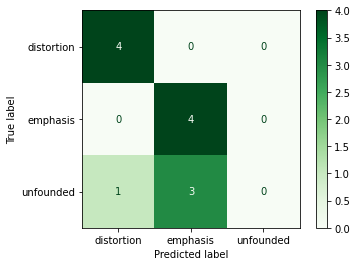

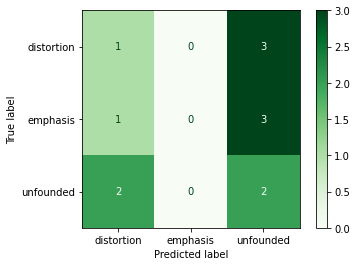

In [279]:
from sklearn.linear_model import RidgeClassifier

# Ridge Classifier Evaluation

ridgeClas = RidgeClassifier()
parameters = {
                'alpha': [0.05, 0.1, 0.5, 1, 2, 5, 10, 20],
                'tol' : [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                'solver': ('auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs')
             }
ridgeClassifier = GridSearchCV(ridgeClas, parameters, n_jobs = -1, cv=10, scoring='accuracy')

bestModel, bestAccuracyTest, bestAccuracyVal, bestParams = HyperParameterTuningTfIdf(summarisationData, ridgeClassifier)

print("\n---- Word2Vec Results----\n")
# Word2Vec
accuracyArrayX, meanF1Score, meanAccuracyX = TenFoldValidation_Word2Vec(summarisationData, bestModel)
print("Mean Accuracy: ", meanAccuracyY, " MeanF1Score",meanF1Score)

In [286]:
from scipy.stats import wilcoxon

# F1 Score Results

gaussianProcessSum = [0.47, 0.19, 0.30, 0.40, 0.57, 0.48, 0.56, 0.46, 0.29, 0.66]
gaussianProcessAtt = [0.39, 0.29, 0.40, 0.56, 0.33, 0.28, 0.13, 0.50, 0.26, 0.46]

kNeighborsSum = [0.26, 0.39, 0.27, 0.48, 0.46, 0.58, 0.76, 0.17, 0.41, 0.39]
kNeighborsAtt = [0.46, 0.39, 0.18, 0.59, 0.34, 0.34, 0.21, 0.28, 0.48, 0.18]

multinomialNBSum = [0.40, 0.31, 0.23, 0.40, 0.57, 0.49, 0.56, 0.54, 0.13, 0.54]
multinomialNBAtt = [0.47, 0.30, 0.15, 0.33, 0.25, 0.24, 0.13, 0.18, 0.16, 0.23]

decisionTreesSum = [0.21, 0.20, 0.31, 0.58, 0.49, 0.25, 0.58, 0.14, 0.22, 0.17]
decisionTreesAtt = [0.44, 0.53, 0.38, 0.59, 0.50, 0.48, 0.07, 0.41, 0.31, 0.56]

In [287]:
w, p = wilcoxon(gaussianProcessSum, gaussianProcessAtt)
print("Wilcoxon Results for Gaussian Process. W: ",w," P: ",p)

w, p = wilcoxon(kNeighborsSum, kNeighborsAtt)
print("Wilcoxon Results for K-Neighbors. W: ",w," P: ",p)

w, p = wilcoxon(multinomialNBSum, multinomialNBAtt)
print("Wilcoxon Results for MultinomialNB. W: ",w," P: ",p)

w, p = wilcoxon(decisionTreesSum, decisionTreesAtt)
print("Wilcoxon Results for Decision Trees. W: ",w," P: ",p)

Wilcoxon Results for Gaussian Process. W:  17.0  P:  0.322265625
Wilcoxon Results for K-Neighbors. W:  14.0  P:  0.3139380937749148
Wilcoxon Results for MultinomialNB. W:  5.0  P:  0.01953125
Wilcoxon Results for Decision Trees. W:  10.0  P:  0.083984375


In [288]:
# Accuracy Score Results

gaussianProcessSum = [0.46, 0.23, 0.31, 0.42, 0.58, 0.50, 0.58, 0.50, 0.33, 0.67]
gaussianProcessAtt = [0.46, 0.38, 0.46, 0.58, 0.42, 0.33, 0.17, 0.50, 0.33, 0.50]

kNeighborsSum = [0.31, 0.38, 0.31, 0.50, 0.50, 0.58, 0.75, 0.25, 0.42, 0.42]
kNeighborsAtt = [0.46, 0.46, 0.15, 0.58, 0.33, 0.42, 0.25, 0.33, 0.50, 0.33]

multinomialNBSum = [0.38, 0.31, 0.23, 0.42, 0.58, 0.50, 0.58, 0.58, 0.17, 0.58]
multinomialNBAtt = [0.46, 0.31, 0.15, 0.33, 0.25, 0.33, 0.17, 0.17, 0.17, 0.25]

decisionTreesSum = [0.23, 0.23, 0.31, 0.58, 0.50, 0.25, 0.58, 0.17, 0.25, 0.25]
decisionTreesAtt = [0.46, 0.54, 0.38, 0.58, 0.50, 0.50, 0.08, 0.42, 0.33, 0.58]

In [289]:
w, p = wilcoxon(gaussianProcessSum, gaussianProcessAtt)
print("Wilcoxon Results for Gaussian Process. W: ",w," P: ",p)

w, p = wilcoxon(kNeighborsSum, kNeighborsAtt)
print("Wilcoxon Results for K-Neighbors. W: ",w," P: ",p)

w, p = wilcoxon(multinomialNBSum, multinomialNBAtt)
print("Wilcoxon Results for MultinomialNB. W: ",w," P: ",p)

w, p = wilcoxon(decisionTreesSum, decisionTreesAtt)
print("Wilcoxon Results for Decision Trees. W: ",w," P: ",p)

Wilcoxon Results for Gaussian Process. W:  6.5  P:  0.2040841777655732
Wilcoxon Results for K-Neighbors. W:  16.0  P:  0.275390625
Wilcoxon Results for MultinomialNB. W:  1.5  P:  0.020394840183375906
Wilcoxon Results for Decision Trees. W:  8.0  P:  0.16142946236708333
